# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Data understanding
We start from the loading of the two csv 

In [2]:
artists_path = 'data\\artists.csv'
tracks_path = 'data\\tracks.csv'

This code automatically detects the correct separator for two dataset files (tracks and artists) by checking which character — comma, semicolon, or tab — appears most in the first line. It then loads each file into a pandas DataFrame using the detected separator, prints their shapes, and displays the first few rows.

 The tracks dataset has 11,166 rows and 45 columns, while the artists dataset has 104 rows and 14 columns.

In [3]:
# Helper function to automatically detect the correct CSV separator
def detect_separator(filepath):
    """
    Reads the first line of a file and counts occurrences of common separators
    (comma, semicolon, tab) to guess which one is most likely used.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.readline()  # Read only the first line as a sample
    
    # Count how many times each possible separator appears in that line
    seps = {
        ',': sample.count(','),
        ';': sample.count(';'),
        '\t': sample.count('\t')
    }
    
    # Choose the separator with the highest count
    best_sep = max(seps, key=seps.get)
    print(f"Detected separator for {filepath}: '{best_sep}'")
    return best_sep


# Automatically detect separators for both CSV files
sep_tracks = detect_separator(tracks_path)
sep_artists = detect_separator(artists_path)

print('------------------------------------')

# Load the datasets using the detected separators
tracks = pd.read_csv(tracks_path, sep=sep_tracks, encoding='utf-8', engine='python')
artists = pd.read_csv(artists_path, sep=sep_artists, encoding='utf-8', engine='python')

# Display basic information for a quick sanity check
print(f"Tracks shape: {tracks.shape}")   # Number of rows and columns in tracks.csv
print(f"Artists shape: {artists.shape}") # Number of rows and columns in artists.csv
print('------------------------------------')

print('TRACKS')
display(tracks.head(3))  # Show first 3 rows of tracks dataset

print('------------------------------------')
print('ARTISTS')
display(artists.head(3)) # Show first 3 rows of artists dataset


Detected separator for data\tracks.csv: ','
Detected separator for data\artists.csv: ';'
------------------------------------
Tracks shape: (11166, 45)
Artists shape: (104, 14)
------------------------------------
TRACKS


,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Oplà, ah\r\nBdope, chiama due b—\r\n\r\nMi can...",False
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Greg Willen, non dormire\r\n(Brr-poh)\r\n\r\nT...",False
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,album,1.0,1.0,193544.0,True,39.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Mothz\r\nYeah, yeah, yeah-yeah\r\nBdope, chiam...",False


------------------------------------
ARTISTS


,id_author,name,gender,birth_date,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude
0,ART82291002,99 posse,M,NaN,NaN,NaN,gruppo musicale italiano,1991-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,ART53496045,achille lauro,M,1990-07-11,Verona,Italia,cantautore e rapper italiano (1990-),2012-01-01,NaN,Verona,Veneto,Italia,45.442498,10.985738
2,ART18853907,alfa,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Initial Analysis 

In this section, we perform an initial exploration of the two datasets, **tracks.csv** and **artists.csv**, to gain a comprehensive understanding of their structure and content.

The goal of this phase is to evaluate the overall **data quality**, identify potential **issues** (such as missing or duplicated records), and understand the **semantic nature** of each feature before moving to deeper analysis and data preparation.

Specifically, the following steps are carried out:

1. **Dataset overview** – Check the number of rows and columns to understand dataset size and complexity.  
2. **Data types and completeness** – Use `.info()` to inspect data types and identify columns with missing values or inconsistencies.  
3. **Missing values analysis** – Quantify and list columns that contain `NaN` or empty values to plan proper imputation or removal strategies.  
4. **Duplicate detection** – Verify whether there are duplicated records that could bias the statistical analysis.  
5. **Descriptive statistics** – Compute central tendency and dispersion metrics (mean, std, min, max, etc.) for all numeric variables.  
6. **Categorical overview** – For each categorical or textual column, check the number of unique categories and display a few example values to understand their variability and semantics.

This exploratory step provides the foundation for subsequent **data cleaning**, **feature engineering**, and **correlation analysis** in the next phases of the project.


In [4]:
# 1. Overview of the datasets
print("=== DATASET OVERVIEW ===")
print(f"Tracks -> rows: {tracks.shape[0]}, columns: {tracks.shape[1]}")
print(f"Artists -> rows: {artists.shape[0]}, columns: {artists.shape[1]}")
print("--------------------------------------\n")


=== DATASET OVERVIEW ===
Tracks -> rows: 11166, columns: 45
Artists -> rows: 104, columns: 14
--------------------------------------


In [5]:
# 2. General info (data types, non-null counts)
print("=== TRACKS DATA INFO ===")
tracks.info()
print("\n=== ARTISTS DATA INFO ===")
artists.info()
print("--------------------------------------\n")

=== TRACKS DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11166 entries, 0 to 11165
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11166 non-null  object 
 1   id_artist             11166 non-null  object 
 2   name_artist           11166 non-null  object 
 3   full_title            11166 non-null  object 
 4   title                 11166 non-null  object 
 5   featured_artists      3517 non-null   object 
 6   primary_artist        11166 non-null  object 
 7   language              11061 non-null  object 
 8   album                 9652 non-null   object 
 9   stats_pageviews       4642 non-null   float64
 10  swear_IT              11166 non-null  int64  
 11  swear_EN              11166 non-null  int64  
 12  swear_IT_words        11166 non-null  object 
 13  swear_EN_words        11166 non-null  object 
 14  year                  10766 non-null  object 

In [6]:
# 3. Missing values summary 
print("=== MISSING VALUES (TRACKS) ===")
missing_tracks = tracks.isna().sum().sort_values(ascending=False)
display(missing_tracks[missing_tracks>0])

print("\n=== MISSING VALUES (ARTISTS) ===")
missing_artists = artists.isna().sum().sort_values(ascending=False)
display(missing_artists[missing_artists>0])
print("--------------------------------------\n")

=== MISSING VALUES (TRACKS) ===


featured_artists        7649
stats_pageviews         6524
album                   1514
day                     1323
month                   1197
year                     400
language                 105
id_album                  78
album_name                78
album_image               78
album_type                78
album_release_date        78
track_number              78
explicit                  78
duration_ms               78
disc_number               78
lexical_density           76
tokens_per_sent           76
n_tokens                  76
char_per_tok              76
n_sentences               76
avg_token_per_clause      76
flatness                  64
flux                      64
zcr                       64
centroid                  64
bpm                       64
rolloff                   64
rms                       64
pitch                     64
spectral_complexity       64
loudness                  64
lyrics                     3
popularity                 2
dtype: int64


=== MISSING VALUES (ARTISTS) ===


active_end      104
active_start     54
region           36
province         34
country          34
nationality      33
birth_place      32
latitude         32
longitude        32
birth_date       31
description      18
dtype: int64

--------------------------------------


In [7]:
# 4. Duplicate records check
print("=== DUPLICATE RECORDS ===")
dup_tracks = tracks.duplicated().sum()
dup_artists = artists.duplicated().sum()
print(f"Duplicated rows in tracks: {dup_tracks}")
print(f"Duplicated rows in artists: {dup_artists}")
print("--------------------------------------\n")

=== DUPLICATE RECORDS ===
Duplicated rows in tracks: 0
Duplicated rows in artists: 0
--------------------------------------


In [8]:
# 5. Descriptive statistics for numeric columns
print("=== NUMERIC SUMMARY (TRACKS) ===")
display(tracks.describe().T)

print("\n=== NUMERIC SUMMARY (ARTISTS) ===")
display(artists.describe().T)
print("--------------------------------------\n")

=== NUMERIC SUMMARY (TRACKS) ===


,count,mean,std,min,25%,50%,75%,max
stats_pageviews,4642.0,36993.646919,58406.564657,5006.0000,9642.250000,19099.500000,42011.750000,1.971207e+06
swear_IT,11166.0,2.343006,3.704831,0.0000,0.000000,1.000000,3.000000,7.200000e+01
swear_EN,11166.0,0.711177,2.555423,0.0000,0.000000,0.000000,0.000000,7.200000e+01
month,9969.0,6.198515,3.482992,1.0000,3.000000,6.000000,10.000000,1.200000e+01
day,9843.0,15.808697,8.881989,1.0000,9.000000,16.000000,23.000000,3.100000e+01
n_sentences,11090.0,59.399639,24.711996,1.0000,46.000000,58.000000,73.000000,4.370000e+02
n_tokens,11090.0,496.891253,209.187612,3.0000,372.000000,491.000000,615.000000,3.089000e+03
tokens_per_sent,11090.0,8.672152,5.675602,1.5000,7.333333,8.404762,9.431527,4.000000e+02
char_per_tok,11090.0,4.054416,0.445958,2.0000,3.866946,4.012709,4.168686,1.200000e+01
lexical_density,11090.0,0.514367,0.061583,0.0000,0.482353,0.511719,0.542450,1.000000e+00



=== NUMERIC SUMMARY (ARTISTS) ===


,count,mean,std,min,25%,50%,75%,max
active_end,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,72.0,43.591374,2.248674,37.747452,41.577547,45.067755,45.464194,45.806691
longitude,72.0,11.060876,2.591871,7.525403,9.189635,9.917118,12.482932,18.225226


--------------------------------------


In [9]:
# 6. Categorical variables: unique values and examples
print("=== CATEGORICAL VARIABLES OVERVIEW (TRACKS) ===")
for col in tracks.select_dtypes(include=['object']).columns:
    unique_count = tracks[col].nunique()
    sample_value = tracks[col].dropna().unique()[:3]
    print(f"{col:25} | unique: {unique_count:<5} | examples: {sample_value}")
    
print("\n=== CATEGORICAL VARIABLES OVERVIEW (ARTISTS) ===")
for col in artists.select_dtypes(include=['object']).columns:
    unique_count = artists[col].nunique()
    sample_value = artists[col].dropna().unique()[:3]
    print(f"{col:25} | unique: {unique_count:<5} | examples: {sample_value}")

=== CATEGORICAL VARIABLES OVERVIEW (TRACKS) ===
id                        | unique: 11093 | examples: ['TR934808' 'TR760029' 'TR916821']
id_artist                 | unique: 104   | examples: ['ART04205421' 'ART19605256' 'ART18853907']
name_artist               | unique: 104   | examples: ['Rosa Chemical' 'Beba' 'Alfa']
full_title                | unique: 11164 | examples: ['\u200bpolka 2 :-/ by\xa0Rosa\xa0Chemical (Ft.\xa0Ernia & Guè)'
 'POLKA by\xa0Rosa\xa0Chemical (Ft.\xa0Thelonious\xa0B.)'
 '\u200bbritney ;-) by\xa0Rosa\xa0Chemical (Ft.\xa0MamboLosco & RADICAL)']
title                     | unique: 10521 | examples: ['\u200bpolka 2 :-/' 'POLKA' '\u200bbritney ;-)']
featured_artists          | unique: 1740  | examples: ['Ernia, Guè' 'Thelonious B.' 'MamboLosco, RADICAL']
primary_artist            | unique: 104   | examples: ['Rosa Chemical' 'Beba' 'Alfa']
language                  | unique: 35    | examples: ['pl' 'en' 'it']
album                     | unique: 890   | examples: ['FOR

## Duplicates


### Artists

The following code checks the artists dataset for duplicates in two ways: first, it looks for identical full rows to detect any completely repeated entries; then, it checks for duplicates specifically based on the artist ID and artist name columns.
<B> After performing both checks, it confirms that there are no duplicate artists in the dataset </B>.

In [10]:
# Check for duplicated artists rows
duplicates_artists = artists[artists.duplicated()]

print(f"Number of duplicated Artists rows: {duplicates_artists.shape[0]}")
display(duplicates_artists.head(5))

Number of duplicated Artists rows: 0


,id_author,name,gender,birth_date,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude


In [11]:
# Check for duplicated artists based on artist id
duplicates_artists_id = artists[artists.duplicated(subset='id_author')]
print(f"Number of duplicated artist based on ID: {duplicates_artists_id.shape[0]}")
display(duplicates_artists_id.head(5))

Number of duplicated artist based on ID: 0


,id_author,name,gender,birth_date,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude


In [12]:
# Check for duplicated artists based on artist name	
duplicates_artists_name = artists[artists.duplicated(subset='name')]
print(f"Number of duplicated artist based on Name: {duplicates_artists_name.shape[0]}")
display(duplicates_artists_name.head(5))

Number of duplicated artist based on Name: 0


,id_author,name,gender,birth_date,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude


### Tracks
Duplicates rows check has been also performed here.
No duplicated rows were detected, indicating that all track entries are unique.

In [13]:
# Check for duplicated tracks rows
duplicates_tracks = tracks[tracks.duplicated()]

print(f"Number of duplicated rows: {duplicates_tracks.shape[0]}")
display(duplicates_tracks.head(5))

Number of duplicated rows: 0


,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity


#### Duplicated Tracks based on ID
This code checks the tracks dataset for duplicates based specifically on the track ID column. It identifies all rows where the same ID appears more than once, counts them, and displays them.
 It first identifies all rows where the same ID appears more than once, counts how many duplicated tracks exist, and displays them. Then, it counts how many times each track ID occurs in the dataset. 

<B> The result shows that there are 73 duplicated rows based on track IDs. 
Precisely we have 71  distinct IDs that have duplicates. </B>

<B>one track ID is repeated four times, while the others are each repeated twice </B>

# Check for duplicated tracks based on track id
duplicates_tracks_id = tracks[tracks.duplicated(subset='id')]
print(f"Number of duplicated Tracks rows based on ID: {duplicates_tracks_id.shape[0]}")
display(duplicates_tracks_id)


# Count how many times each id_track appears
id_counts = tracks['id'].value_counts()
duplicate_id_counts = id_counts[id_counts > 1]

print('Number of distinct IDs that have duplicates')
print(duplicate_id_counts.size)
print("Number of tracks for each id:")
print(duplicate_id_counts)


The following code lists every full_title associated with each duplicated track ID. The results show 71 duplicated IDs in total. Most of these IDs are linked to two different songs, except for one ID that is associated with four songs (two pairs sharing the same title).


In [14]:
# Find all duplicated track IDs
duplicate_ids = tracks[tracks.duplicated(subset='id', keep=False)]

# Group by 'id' and list all titles
titles_per_id = duplicate_ids.groupby('id')['full_title'].apply(list)

# Display each ID with all titles and the count of unique titles
for track_id, titles in titles_per_id.items():
    unique_count = len(set(titles))  # number of unique titles
    print(f"Track ID: {track_id} Number(of total songs: {len(titles)})(Unique titles: {unique_count})")
    for title in titles:
        print(f"  - {title}")
    print('----------------------------------------------------------')


Track ID: TR108862 Number(of total songs: 2)(Unique titles: 2)
  - Sushi Bar by Bassi Maestro
  - SPINE by Noyz Narcos (Ft. Coez)
----------------------------------------------------------
Track ID: TR135764 Number(of total songs: 2)(Unique titles: 2)
  - Nessuno vale quanto te by Ghemon
  - Giovani eroi by Emis Killa (Ft. Not Good)
----------------------------------------------------------
Track ID: TR190585 Number(of total songs: 2)(Unique titles: 2)
  - Serpico by Piotta (Ft. Tiromancino)
  - Nei treni la notte by Coez (Ft. Frah Quintale)
----------------------------------------------------------
Track ID: TR192351 Number(of total songs: 2)(Unique titles: 2)
  - Tornerò Da Re - Redrum Version by Club Dogo
  - Musica Commerciale by Jake La Furia
----------------------------------------------------------
Track ID: TR205970 Number(of total songs: 2)(Unique titles: 2)
  - 24.7 by Jack The Smoker (Ft. Bassi Maestro & Guè)
  - Sigla Catteland by Rancore & DJ Myke
-------------------------

#### Duplicated Tracks based on Title
The following code identifies tracks that share the same full_title, meaning duplicate song titles. We found four duplicated tracks, corresponding to two pairs of songs with identical titles.

In [15]:
# Find duplicated full_title
duplicate_titles = tracks[tracks.duplicated(subset='full_title', keep=False)]

# Sort by full_title to see them together
duplicate_titles = duplicate_titles.sort_values('full_title')

print(f"Tracks with duplicate track based on full_title: {duplicate_titles.shape[0]}")
display(duplicate_titles)


Tracks with duplicate track based on full_title: 4


,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity
4627,TR367132,ART20729624,Madame,BUGIE by Madame (Ft. Carl Brave & Rkomi),BUGIE,"Rkomi, Carl Brave",Madame,it,MADAME,36960.0,...,album,1.0,6.0,171602.0,False,48.0,https://i.scdn.co/image/ab67616d0000b2733ccb55...,ALB468764,E visto che non so dire di no\r\nSintomi da st...,False
4628,TR367132,ART20729624,Madame,BUGIE by Madame (Ft. Carl Brave & Rkomi),BUGIE,"Rkomi, Carl Brave",Madame,it,MADAME,36960.0,...,single,1.0,1.0,187660.0,False,42.0,https://i.scdn.co/image/ab67616d0000b27343c750...,ALB590629,E visto che non so dire di no\r\nSintomi da st...,False
4647,TR367132,ART20729624,Madame,​sentimi by Madame,​sentimi,NaN,Madame,it,NaN,14015.0,...,album,1.0,6.0,171602.0,False,48.0,https://i.scdn.co/image/ab67616d0000b2733ccb55...,ALB468764,Eh-eh-ah\r\nSiedi e sentimi\r\nYeah\r\n\r\nSie...,False
4648,TR367132,ART20729624,Madame,​sentimi by Madame,​sentimi,NaN,Madame,it,NaN,14015.0,...,single,1.0,1.0,187660.0,False,42.0,https://i.scdn.co/image/ab67616d0000b27343c750...,ALB590629,Eh-eh-ah\r\nSiedi e sentimi\r\nYeah\r\n\r\nSie...,False


## Merging the Datasets


Merging the tracks and artists datasets into a single DataFrame called df. It matches rows where the <B> id_artist column in tracks</B> corresponds to the <B>id_author column in artists</B>, using a left join so that all tracks are kept even if some artists are missing. After merging, it prints the number of rows and columns in the unified dataset and shows the first three rows for inspection.

In [16]:
df = tracks.merge(artists, left_on='id_artist', right_on='id_author', how='left')

print(f"Unified dataset: {df.shape[0]} rows , {df.shape[1]} columns")
display(df.head(3))

Unified dataset: 11166 rows , 59 columns


,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,Grugliasco,Italia,rapper e cantautore italiano (1998-),2015-01-01,NaN,Torino,Piemonte,Italia,45.068046,7.57762
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,Grugliasco,Italia,rapper e cantautore italiano (1998-),2015-01-01,NaN,Torino,Piemonte,Italia,45.068046,7.57762
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,Grugliasco,Italia,rapper e cantautore italiano (1998-),2015-01-01,NaN,Torino,Piemonte,Italia,45.068046,7.57762


Checking if there is a track without an artist

In [17]:
# Check for tracks without a matching artist
missing_artists = df[df['id_author'].isna()]

print(f"Number of tracks without an artist: {missing_artists.shape[0]}")
display(missing_artists.head(5))

Number of tracks without an artist: 0


,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude


Checking if there is an artist without a track

In [18]:
missing_artists = artists[~artists['id_author'].isin(tracks['id_artist'])]
print("Number of artists without any tracks:", len(missing_artists))

Number of artists without any tracks: 0


## Missing Values
This code analyzes missing values in the DataFrame by counting how many entries are NaN for each column and calculating the corresponding percentage. It creates a summary table showing only columns with missing data, sorted by the highest percentage.

In [19]:
# Calculate total number of missing values per column
missing_count = df.isna().sum()

# Calculate percentage of missing values relative to dataset length
missing_percent = (missing_count/ len(df))*100

# Create a summary DataFrame with count and percentage of missing values
missing_df = (
    pd.DataFrame({
        'missing_count': missing_count,
        'missing_percent': missing_percent
    })
    .sort_values('missing_percent', ascending=False)   # Sort columns by missing percentage
    .query('missing_percent > 0')                      # Keep only columns with missing data
)

# Display the summary table 
display(
    missing_df.style.background_gradient(subset=['missing_percent'], cmap='RdPu') \
    .format({'missing_percent': '{:.2f}%'})
)


,missing_count,missing_percent
active_end,11166,100.00%
featured_artists,7649,68.50%
stats_pageviews,6524,58.43%
active_start,4601,41.21%
region,3142,28.14%
province,2699,24.17%
country,2699,24.17%
nationality,2609,23.37%
birth_place,2578,23.09%
latitude,2578,23.09%


The following heatmap visualizes missing values in the dataset, with each row representing a record and each column a feature. Colored cells indicate missing entries, providing a clear overview of where data is incomplete.


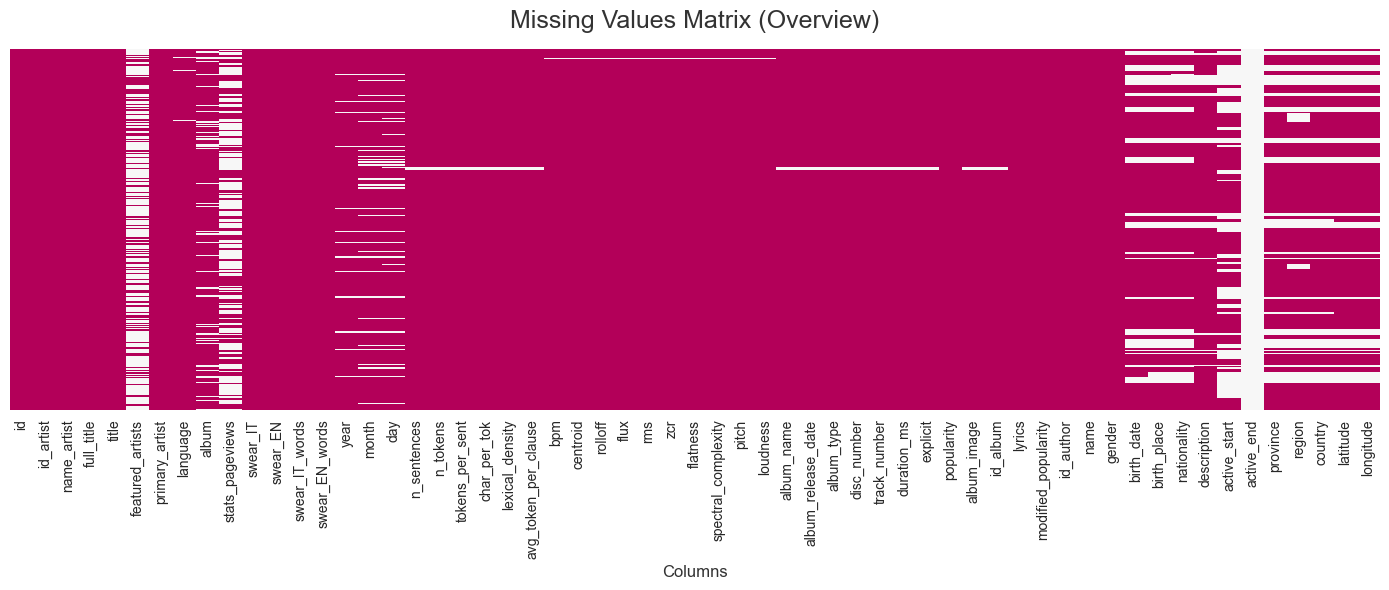

In [20]:
plt.figure(figsize=(14, 6))

# Create the heatmap (NaN = 1, non-NaN = 0)
sns.heatmap(
    df.isna(),
    cbar=False,                     # Hide colorbar for cleaner view
    cmap=sns.color_palette(["#b30059", "#F7F7F7"]),  # White = valid, Magenta = missing
    yticklabels=False               # Hide row labels for readability
)

# Title and labels with good contrast
plt.title("Missing Values Matrix (Overview)", fontsize=18, pad=15, color="#333333")
plt.xlabel("Columns", fontsize=12, color="#333333")
plt.ylabel("")
plt.tight_layout()
plt.show()

The following bar plot shows the percentage of missing values per feature, with the top 20 features that have the most missing data


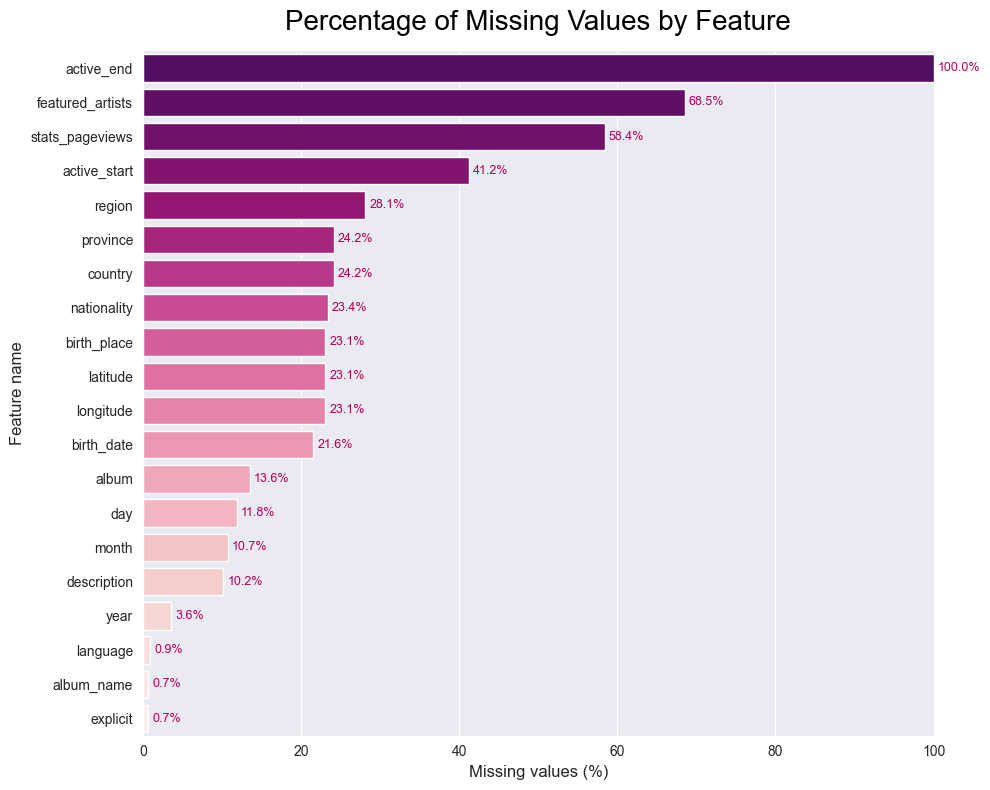

In [21]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=missing_df.head(20),
    x='missing_percent',
    y=missing_df.head(20).index,
    hue=missing_df.head(20).index,  
    palette='RdPu_r'  
)
plt.title("Percentage of Missing Values by Feature", fontsize=20, pad=15, color="#000000")
plt.xlabel("Missing values (%)", fontsize=12)
plt.ylabel("Feature name", fontsize=12)

# Etichette percentuali
for index, value in enumerate(missing_df.head(20)['missing_percent']):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=9, color='#b30059')

plt.xlim(0, 100)
sns.despine()
plt.tight_layout()
plt.show()

#### Missing Values Propagation After Merge


In [22]:
artists_missing = artists.isna().mean().sort_values(ascending=False) * 100
print(artists_missing)

active_end      100.000000
active_start     51.923077
region           34.615385
province         32.692308
country          32.692308
nationality      31.730769
birth_place      30.769231
latitude         30.769231
longitude        30.769231
birth_date       29.807692
description      17.307692
gender            0.000000
id_author         0.000000
name              0.000000
dtype: float64


The visualization highlights that missing values in attributes such as active_start, region, and birth_place have increased after merging due to the replication of incomplete artist metadata across multiple tracks.
This confirms that the merge process did not introduce new nulls, but propagated pre-existing ones.

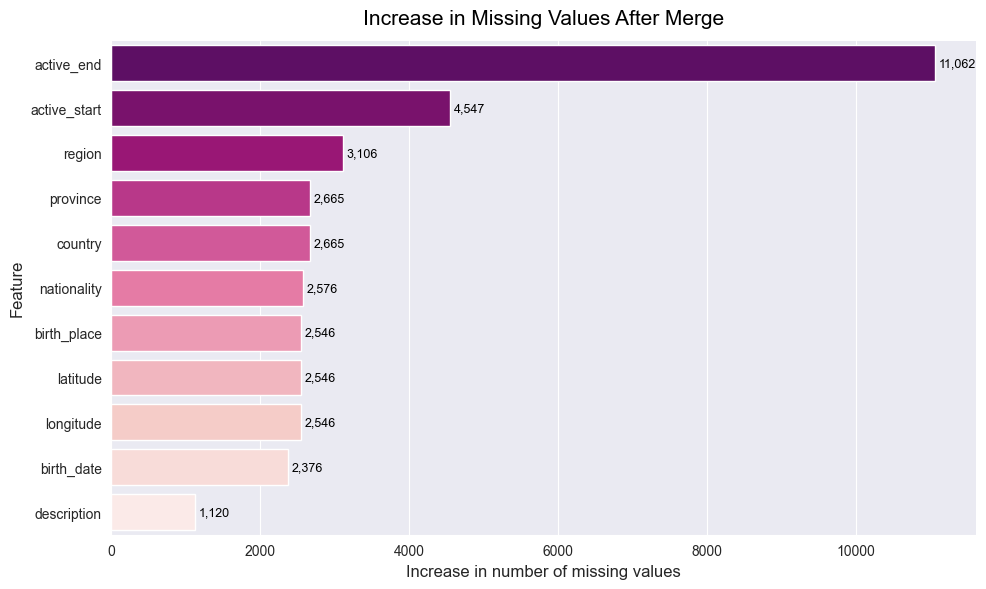

In [23]:
# Colonne provenienti dal dataset artists 
artist_cols =list(artists.columns)

# Conta i NaN prima e dopo il merge
missing_before = artists[artist_cols].isna().sum()
missing_after = df[artist_cols].isna().sum()

# Differenza assoluta e percentuale
missing_diff = missing_after - missing_before
increase_percent = (missing_diff / missing_before.replace(0, pd.NA)) * 100

# Tabella riepilogativa
missing_summary = (
    pd.DataFrame({
        "missing_before": missing_before,
        "missing_after": missing_after,
        "difference": missing_diff,
        "increase_%": increase_percent
    })
    .sort_values("difference", ascending=False)
)

plot_df = missing_summary[missing_summary['difference'] > 0].copy()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x='difference',
    y=plot_df.index,
    hue=plot_df.index,
    palette='RdPu_r'
)
plt.title("Increase in Missing Values After Merge", fontsize=15, pad=12, color="#000000")
plt.xlabel("Increase in number of missing values", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Etichette numeriche a fianco delle barre
for index, value in enumerate(plot_df['difference']):
    plt.text(value + 50, index, f"{int(value):,}", va='center', fontsize=9, color="#000000")

sns.despine()
plt.tight_layout()
plt.show()

After analyzing the percentage of missing values in each column, We need to better understand the overall data quality before applying any filling strategies. Cleaning and validating the data first ensures that missing values are handled correctly and that no incorrect or misleading information is introduced during imputation.

## Correlation Analysis

This section explores the linear relationships between numerical features in the datasets.  
The **Pearson correlation coefficient** is used to measure how strongly two variables move together.

The analysis is conducted separately for:
- **tracks.csv** → to understand relationships among audio, linguistic, and popularity features;
- **artists.csv** → to explore dependencies between demographic and career-related attributes;
- and finally on the **merged dataset**, combining both perspectives.

Interpreting the heatmaps:
- **+1** → strong positive correlation (variables increase together)  
- **−1** → strong negative correlation (one increases while the other decreases)  
- **0** → little or no linear relationship

This step helps identify redundant variables, reveal patterns between audio and artist features,  
and guide feature selection and dimensionality reduction before modeling.

In [24]:
def plot_correlation_heatmap(df, title):
    """Plot a Pearson correlation heatmap for numeric features (white–magenta color scheme)."""
    
    # Select numeric columns
    numeric_df = df.select_dtypes(include=['number'])
    if numeric_df.shape[1] < 2:
        print(f"Skipping {title}: not enough numeric columns.")
        return
    
    # Compute Pearson correlation matrix
    corr_matrix = numeric_df.corr(method='pearson')
    
    # Define custom color palette (white → light magenta → dark magenta)
    cmap = sns.color_palette(["#F6D6FF", "#E5A4FF", "#D873FF", "#C43EFF", "#9B00CC"])

    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        cmap=cmap,         # Custom magenta palette
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'}
    )
    
    # Style adjustments
    plt.title(f"Correlation Heatmap – {title}", fontsize=16, pad=15, color="#333333")
    plt.xticks(rotation=45, ha='right', color="#333333")
    plt.yticks(rotation=0, color="#333333")
    plt.tight_layout()
    plt.show()


=== Correlation Heatmap: TRACKS dataset ===


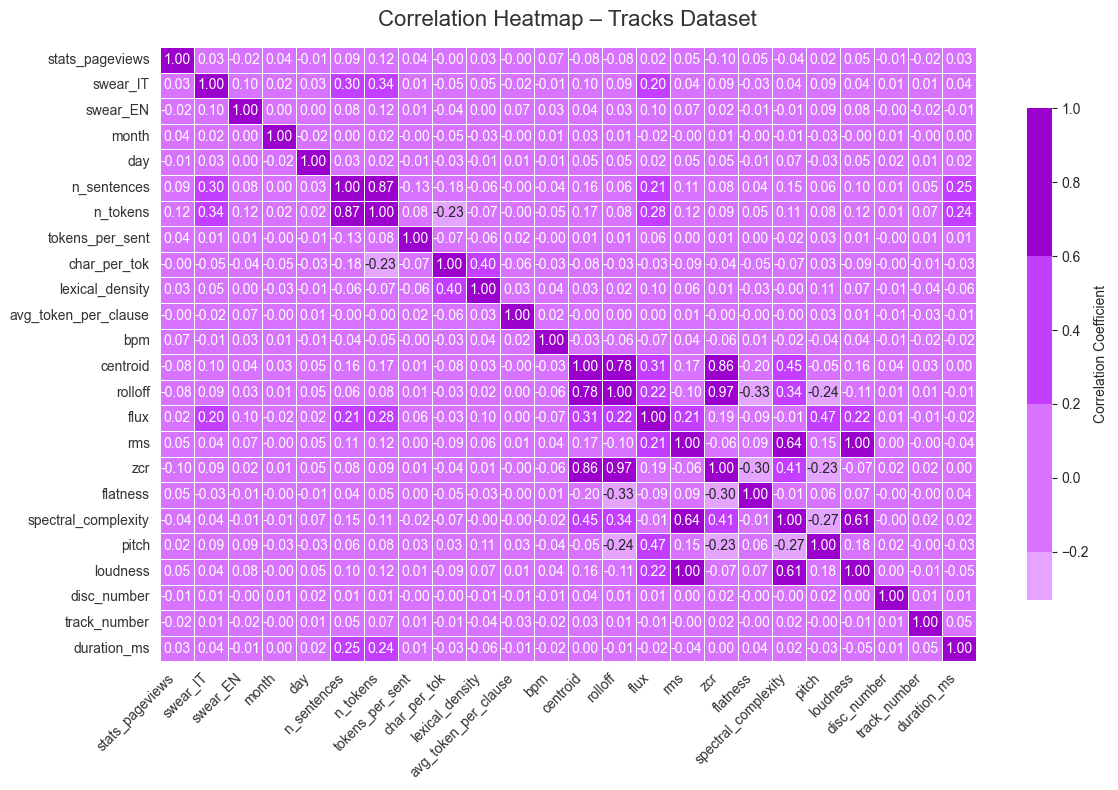

=== Correlation Heatmap: ARTISTS dataset ===


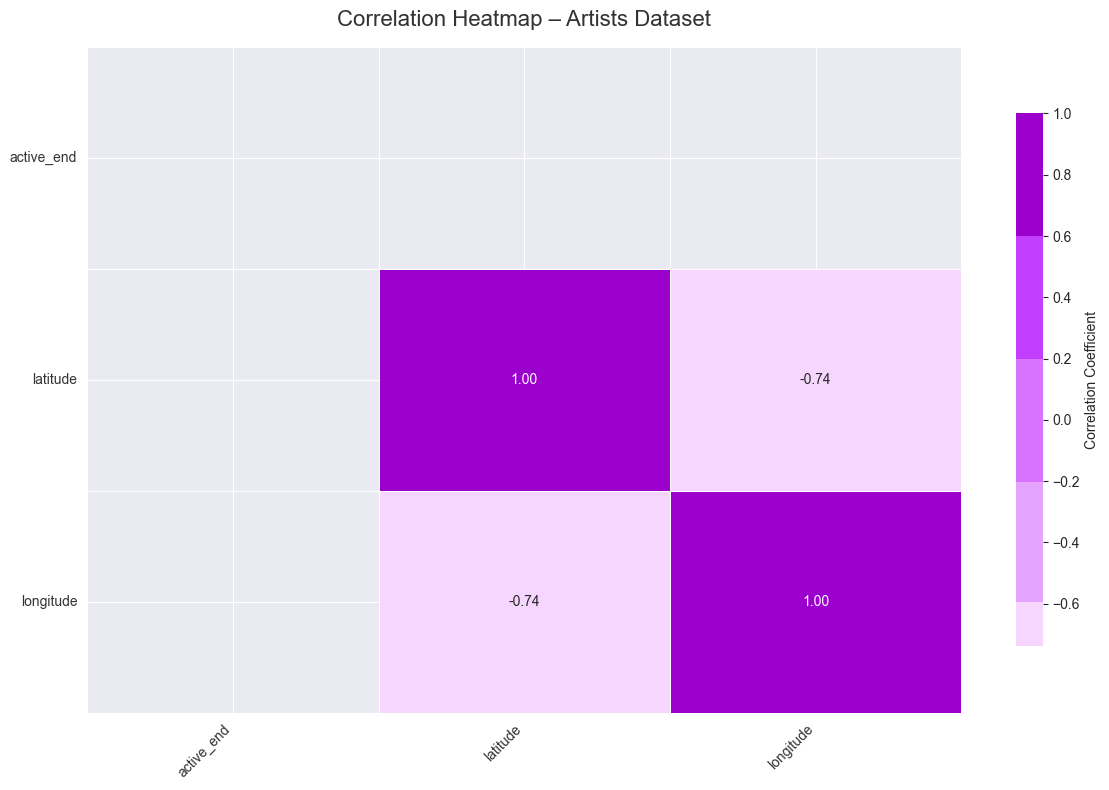

=== Correlation Heatmap: MERGED dataset ===


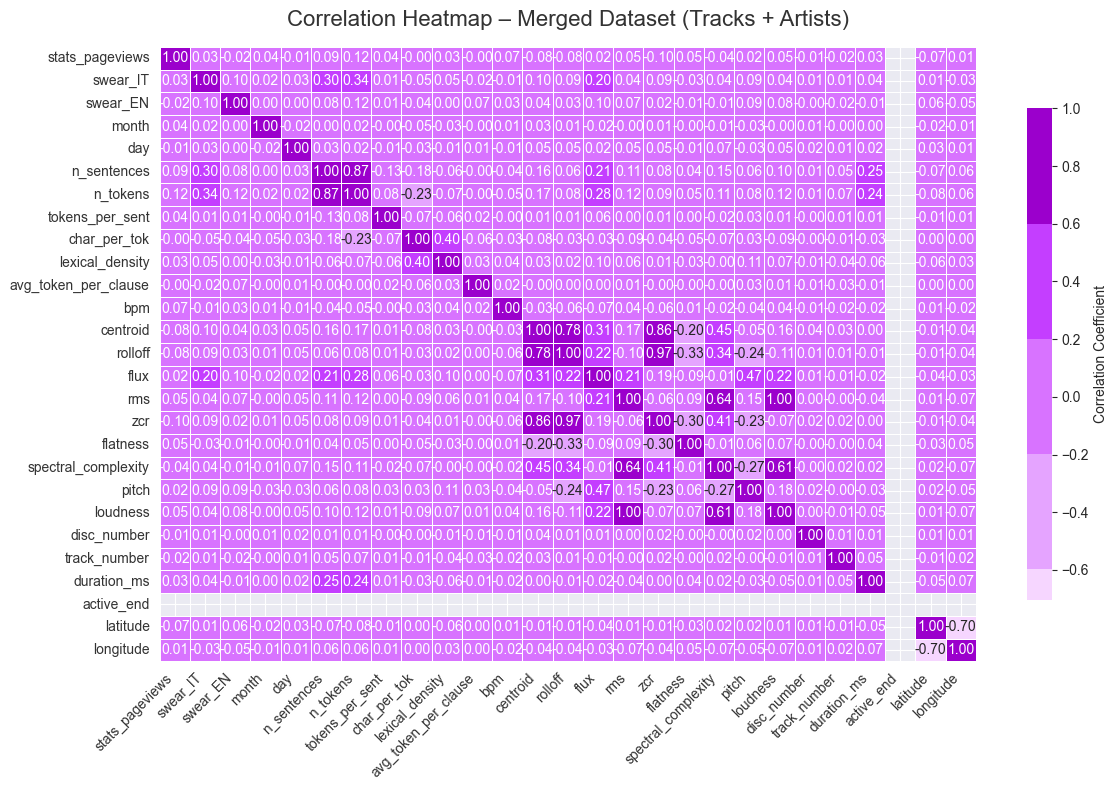

In [25]:
# Correlation Heatmap for TRACKS dataset
print("=== Correlation Heatmap: TRACKS dataset ===")
plot_correlation_heatmap(tracks, "Tracks Dataset")

# Correlation Heatmap for ARTISTS dataset
print("=== Correlation Heatmap: ARTISTS dataset ===")
plot_correlation_heatmap(artists, "Artists Dataset")

# Correlation Heatmap for MERGED dataset (df)
print("=== Correlation Heatmap: MERGED dataset ===")
plot_correlation_heatmap(df, "Merged Dataset (Tracks + Artists)")

### Correlation popularity


### Data Distribution


In [26]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11166 entries, 0 to 11165
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11166 non-null  object 
 1   id_artist             11166 non-null  object 
 2   name_artist           11166 non-null  object 
 3   full_title            11166 non-null  object 
 4   title                 11166 non-null  object 
 5   featured_artists      3517 non-null   object 
 6   primary_artist        11166 non-null  object 
 7   language              11061 non-null  object 
 8   album                 9652 non-null   object 
 9   stats_pageviews       4642 non-null   float64
 10  swear_IT              11166 non-null  int64  
 11  swear_EN              11166 non-null  int64  
 12  swear_IT_words        11166 non-null  object 
 13  swear_EN_words        11166 non-null  object 
 14  year                  10766 non-null  object 
 15  month              

The following table and histogram show the numerical data distribution in the dataset:

- **Most features** (`n_sentences`, `n_tokens`, `tokens_per_sent`, `char_per_tok`, `lexical_density`, `avg_token_per_clause`, `centroid`, `rolloff`, `rms`, `zcr`, `flatness`, `flux`, `spectral_complexity`, `pitch`, `loudness`) show **bell-shaped or near-normal distributions**.

- **Highly skewed features** (`stats_pageviews`, `bpm`, `tokens_per_sent`, `duration_ms`, `popularity`) have a **long right tail**, indicating a few extreme values or outliers (common in popularity or count-based features).

- **Temporal features** (`year`, `month`, `day`) display **non-uniform distributions**; e.g., `year` is concentrated around recent decades, showing most songs are modern.

- **Geographical features** (`latitude`, `longitude`) have **peaks corresponding to specific locations**, likely representing where artists or tracks are clustered.


,count,mean,std,min,25%,50%,75%,max
stats_pageviews,4642.000000,36993.646919,58406.564657,5006.000000,9642.250000,19099.500000,42011.750000,1971207.000000
swear_IT,11166.000000,2.343006,3.704831,0.000000,0.000000,1.000000,3.000000,72.000000
swear_EN,11166.000000,0.711177,2.555423,0.000000,0.000000,0.000000,0.000000,72.000000
month,9969.000000,6.198515,3.482992,1.000000,3.000000,6.000000,10.000000,12.000000
day,9843.000000,15.808697,8.881989,1.000000,9.000000,16.000000,23.000000,31.000000
n_sentences,11090.000000,59.399639,24.711996,1.000000,46.000000,58.000000,73.000000,437.000000
n_tokens,11090.000000,496.891253,209.187612,3.000000,372.000000,491.000000,615.000000,3089.000000
tokens_per_sent,11090.000000,8.672152,5.675602,1.500000,7.333333,8.404762,9.431527,400.000000
char_per_tok,11090.000000,4.054416,0.445958,2.000000,3.866946,4.012709,4.168686,12.000000
lexical_density,11090.000000,0.514367,0.061583,0.000000,0.482353,0.511719,0.542450,1.000000


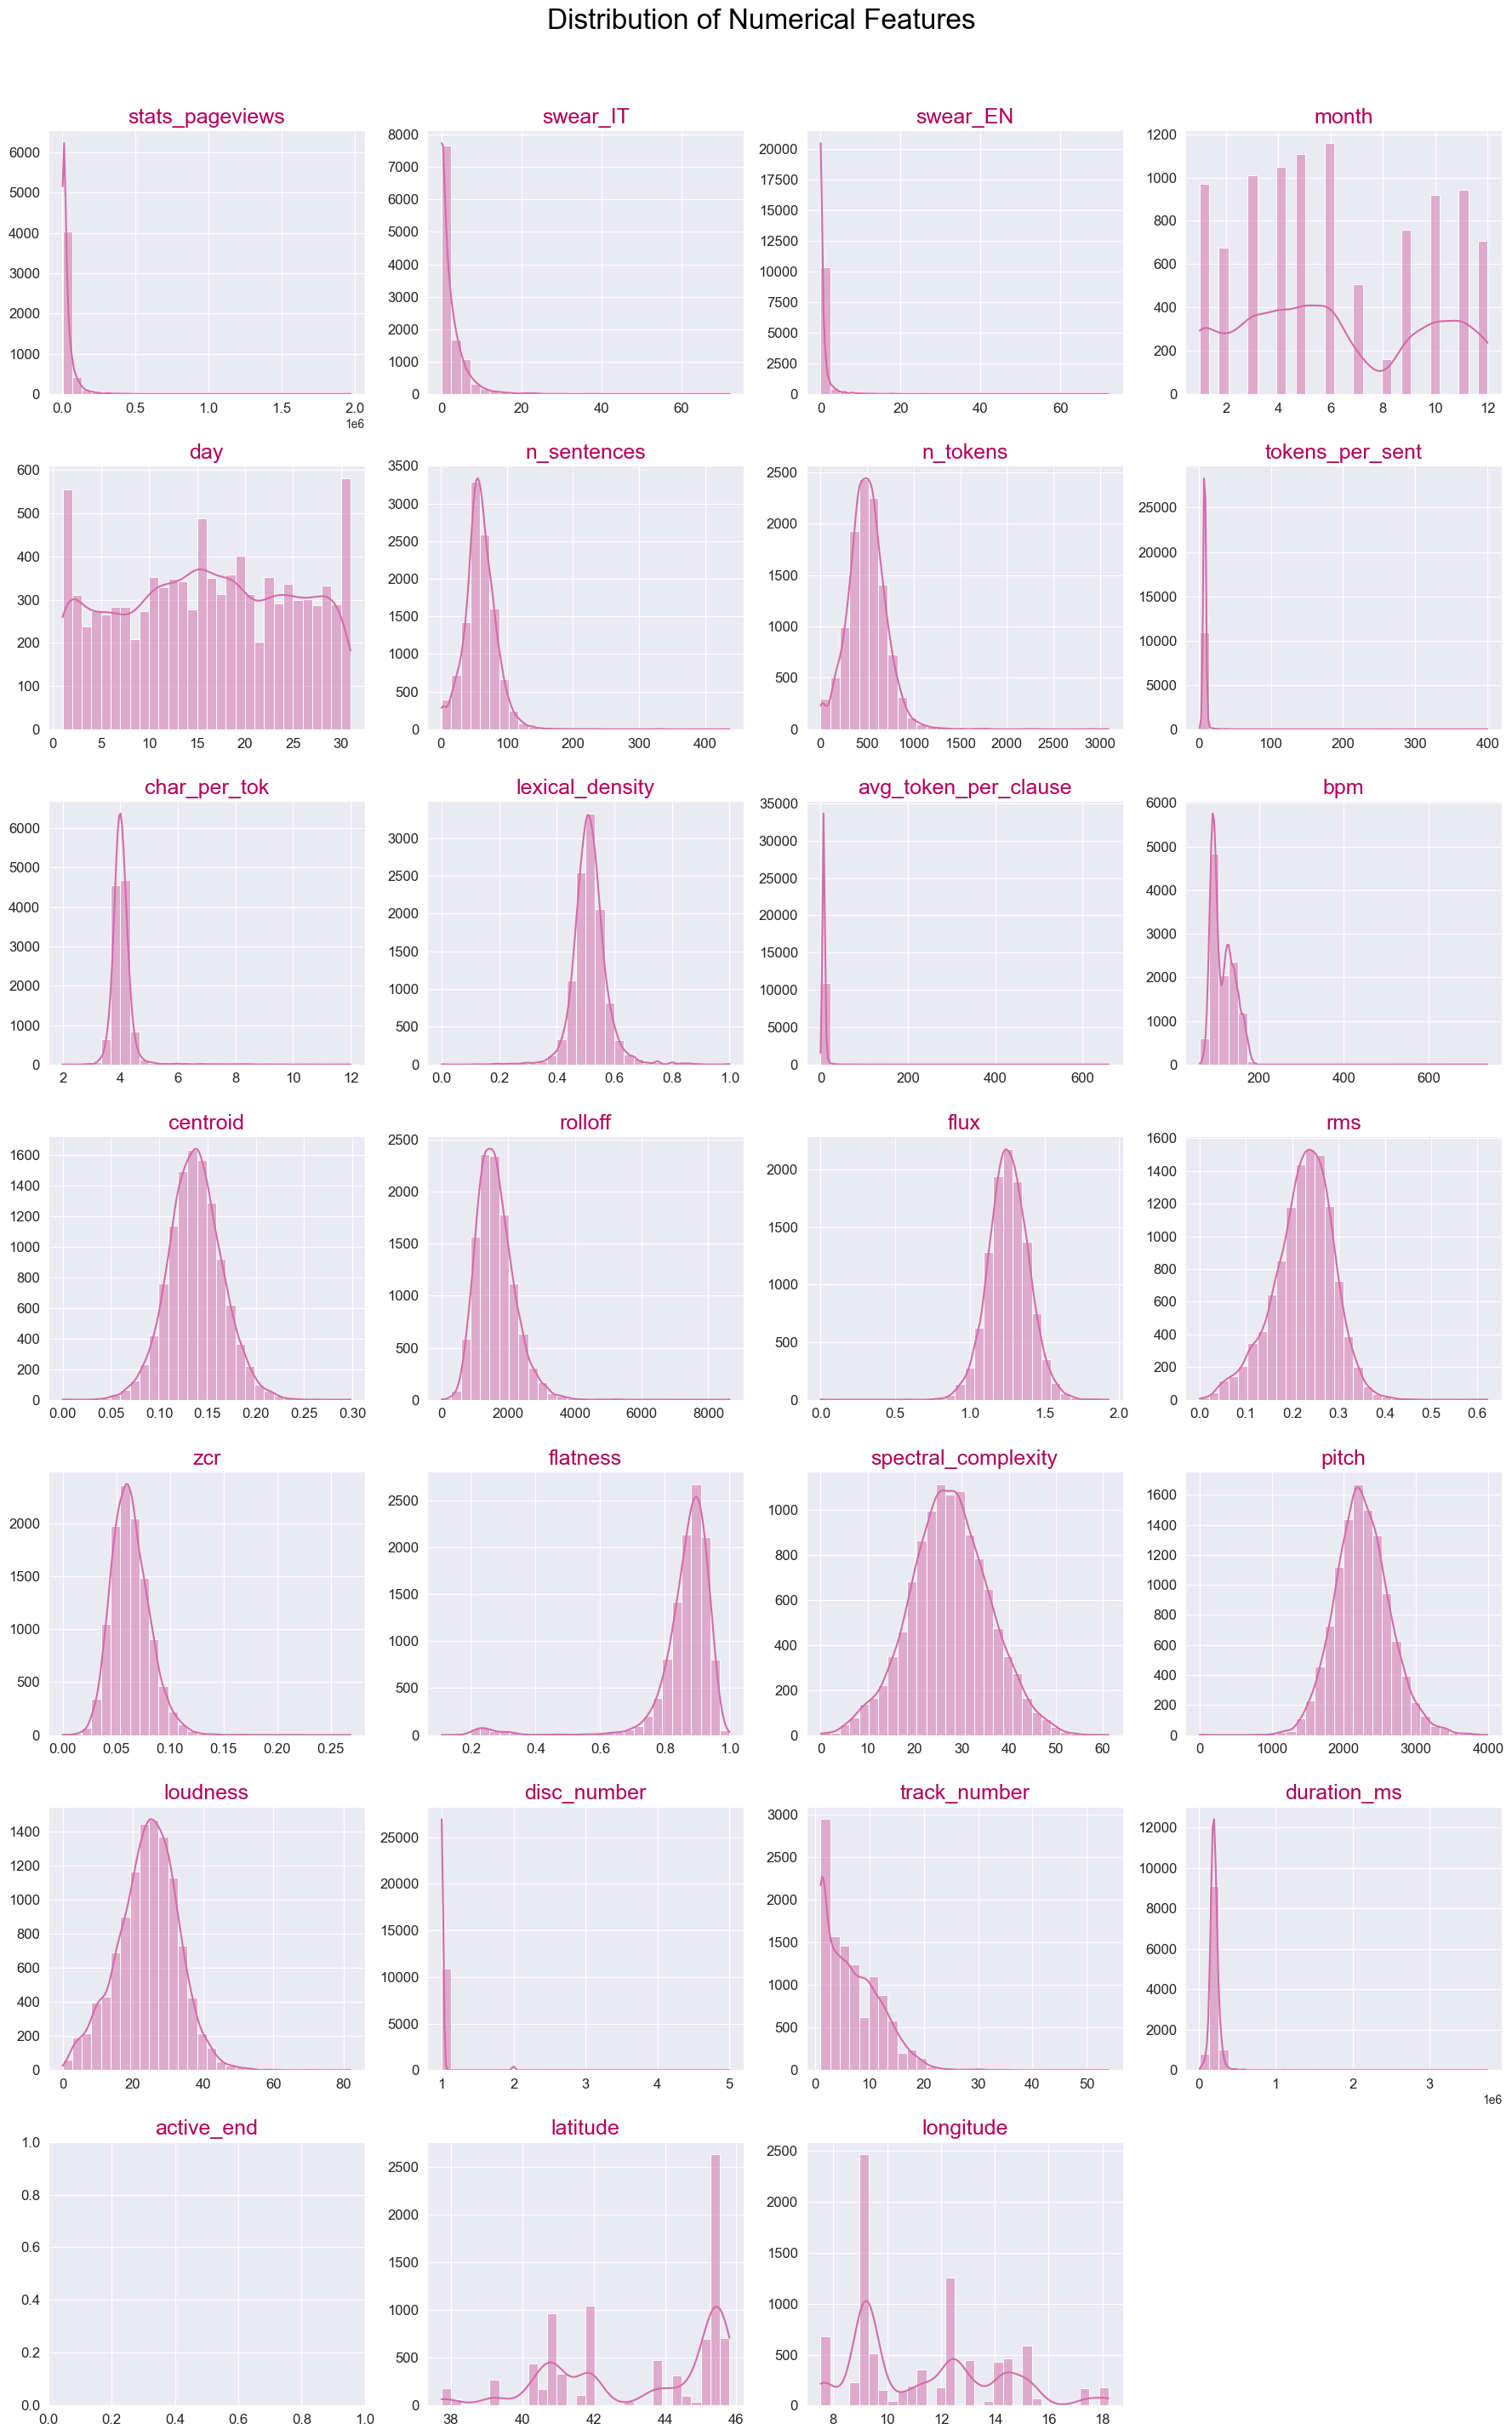

In [27]:

# Select numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# --- Summary statistics table ---
display(df[num_cols].describe().T.style.background_gradient(cmap='RdPu'))

# --- Histograms for each numeric column ---
n_cols = 4
n_rows = -(-len(num_cols) // n_cols)  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), bins=30, kde=True, color="#d36ba8", ax=axes[i])
    axes[i].set_title(col, fontsize=18, color="#b30059")   # larger title font
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='both', labelsize=12)          # larger tick labels

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Numerical Features", fontsize=24, color="#000000", y=1.02)  # larger main title
plt.tight_layout()
plt.show()


The data distribution and the statistics presented above reveal some anomalies and irregularities in the dataset. These issues will be examined and addressed in the following section.


### Consistency check

In [28]:
current_year = 2025

# Ensure numeric types where needed
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['duration_ms'] = pd.to_numeric(df['duration_ms'], errors='coerce')
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

# --- Songs released in the future ---
future_songs = df[df['year'] > current_year]
print(f"Songs released after {current_year}: {len(future_songs)}")

# --- Negative or zero duration ---
invalid_duration = df[df['duration_ms'] <= 0]
print(f"Songs with non-positive duration: {len(invalid_duration)}")

# --- Popularity outside 0–100 ---
invalid_pop = df[(df['popularity'] < 0) | (df['popularity'] > 100)]
print(f"Songs with invalid popularity (outside 0–100): {len(invalid_pop)}")

# --- Artists born after their song release ---
df['birth_year'] = pd.to_datetime(df['birth_date'], errors='coerce').dt.year
invalid_birth = df[df['birth_year'] > df['year']]
print(f"Artists born after the song release year: {len(invalid_birth)}")

# --- Artists with unrealistic age at release (<10 or >100) ---
df['artist_age_at_release'] = df['year'] - df['birth_year']
invalid_age = df[(df['artist_age_at_release'] < 10) | (df['artist_age_at_release'] > 100)]
print(f"Artists with unrealistic age (<10 or >100) at release: {len(invalid_age)}")

# --- Artists with inconsistent active period ---
df['active_start_year'] = pd.to_datetime(df['active_start'], errors='coerce').dt.year
df['active_end_year'] = pd.to_datetime(df['active_end'], errors='coerce').dt.year
invalid_active = df[
    (df['active_end_year'].notna()) &
    (df['active_start_year'] > df['active_end_year'])
]
print(f"Artists with invalid active period (start > end): {len(invalid_active)}")


Songs released after 2025: 1036
Songs with non-positive duration: 0
Songs with invalid popularity (outside 0–100): 49
Artists born after the song release year: 869
Artists with unrealistic age (<10 or >100) at release: 1106
Artists with invalid active period (start > end): 0


In [29]:
# --- Count how many unique artists are involved in each type of anomaly ---

def count_duplicate_artists(subset_df, label):
    if subset_df.empty:
        print(f"{label}: 0 anomalies found.")
        return
    total = len(subset_df)
    unique_artists = subset_df['name_artist'].nunique()
    duplicates = total - unique_artists
    print(f"{label}: {total} rows, {unique_artists} unique artists ({duplicates} repeated).")

print("=== DUPLICATE ARTIST CHECKS FOR ANOMALIES ===")

count_duplicate_artists(future_songs, "Songs released after 2025")
count_duplicate_artists(invalid_duration, "Non-positive duration")
count_duplicate_artists(invalid_pop, "Invalid popularity (outside 0–100)")
count_duplicate_artists(invalid_birth, "Artists born after song release")
count_duplicate_artists(invalid_age, "Unrealistic artist age (<10 or >100)")
count_duplicate_artists(invalid_active, "Invalid active period (start > end)")


=== DUPLICATE ARTIST CHECKS FOR ANOMALIES ===
Songs released after 2025: 1036 rows, 98 unique artists (938 repeated).
Non-positive duration: 0 anomalies found.
Invalid popularity (outside 0–100): 49 rows, 4 unique artists (45 repeated).
Artists born after song release: 869 rows, 72 unique artists (797 repeated).
Unrealistic artist age (<10 or >100): 1106 rows, 72 unique artists (1034 repeated).
Invalid active period (start > end): 0 anomalies found.



# Outliers Detection

In [30]:
df_clean = df.copy()
print(f"Original size: {df_clean.shape}")

# Handle critical NaNs
df_clean = df_clean.dropna(subset=['lyrics'])
print(f"Rows with missing 'lyrics' removed.")
print(f"Size after handling NaNs: {df_clean.shape}")

Original size: (11166, 63)
Rows with missing 'lyrics' removed.
Size after handling NaNs: (11163, 63)


In [31]:
# Numerical Feature Definition

# List of key numerical columns to analyze
numerical_features = [
    'stats_pageviews', 'swear_IT', 'swear_EN',
    'n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'lexical_density', 'avg_token_per_clause',
    'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness',
    'duration_ms', 'popularity'
]

# Ensure all are numeric and remove any rows with NaNs
df_clean[numerical_features] = df_clean[numerical_features].apply(pd.to_numeric, errors='coerce')
df_clean = df_clean.dropna(subset=numerical_features)
print(f"DataFrame ready for outlier analysis. Size: {df_clean.shape}")

DataFrame ready for outlier analysis. Size: (4635, 63)


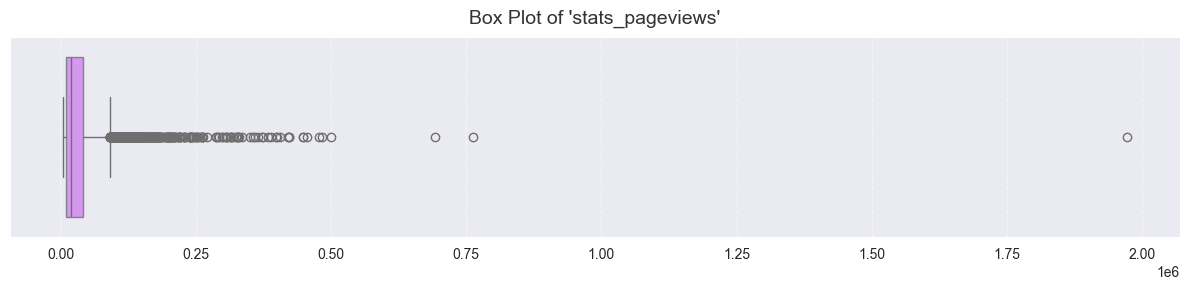

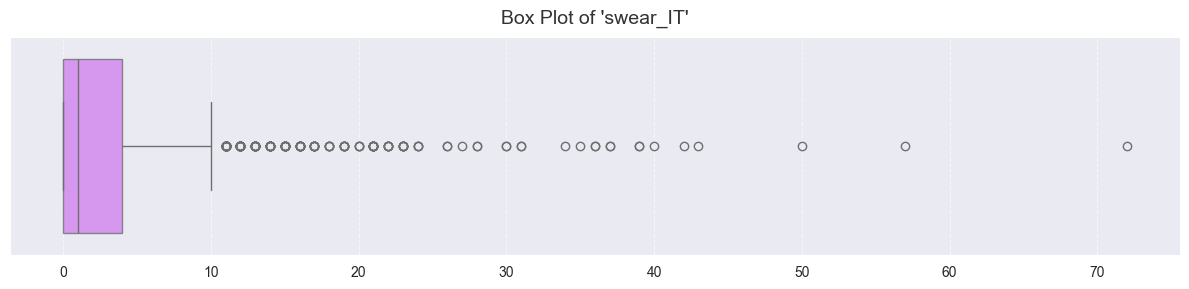

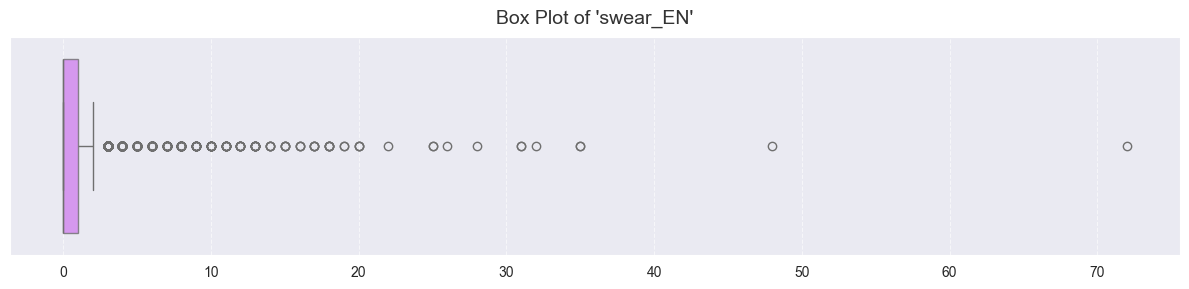

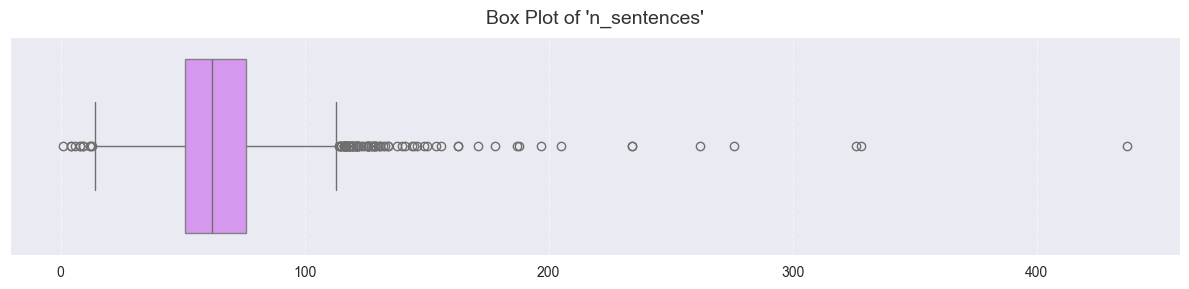

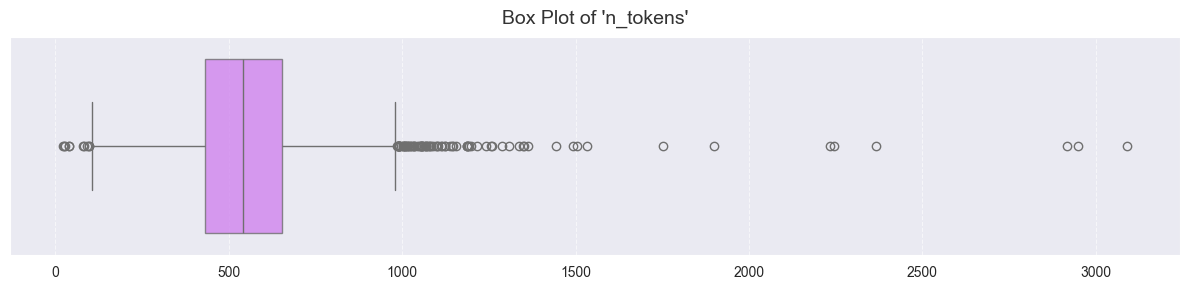

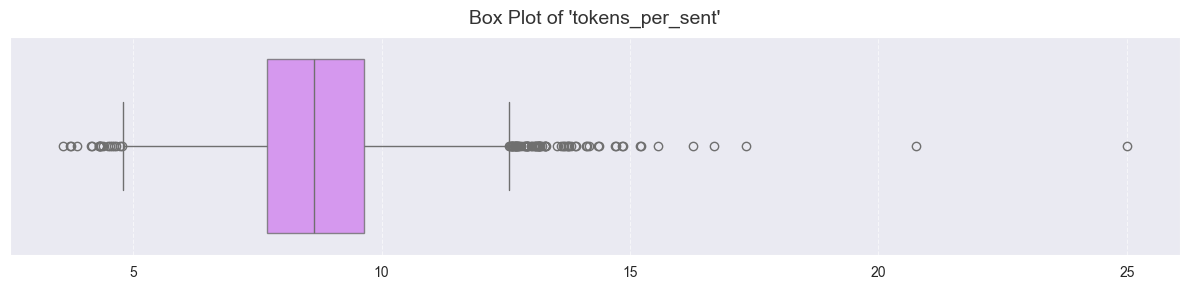

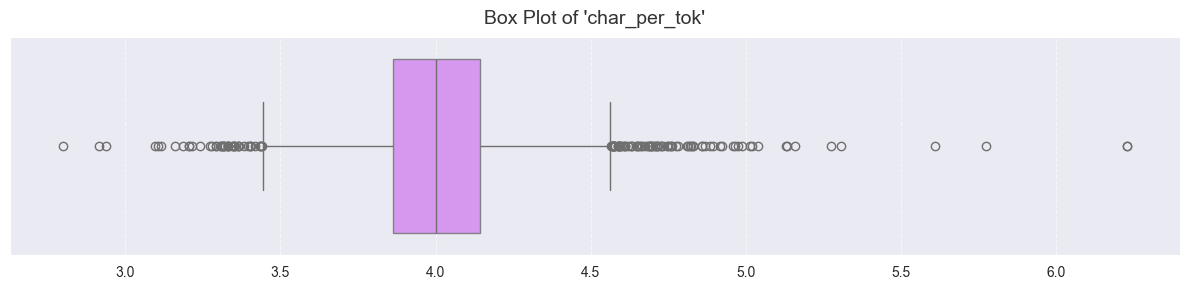

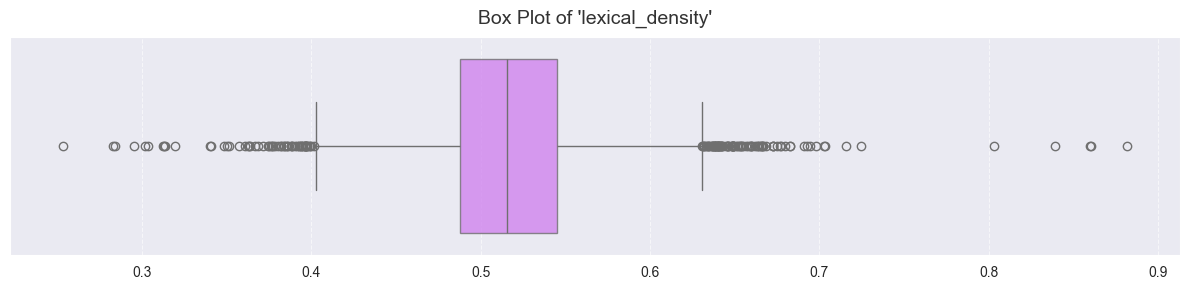

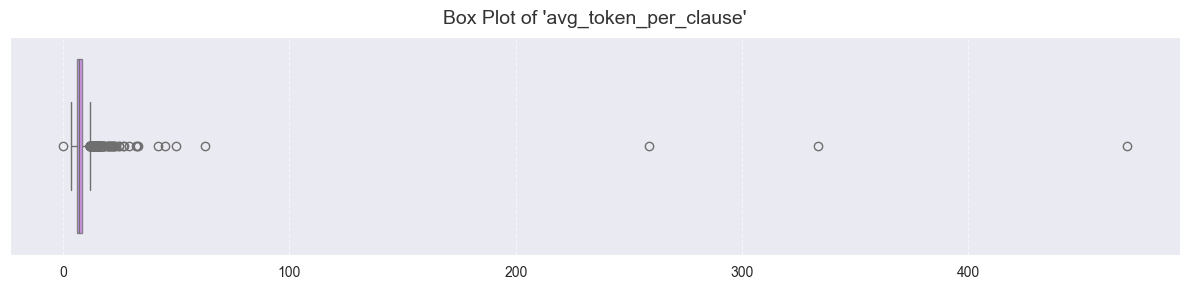

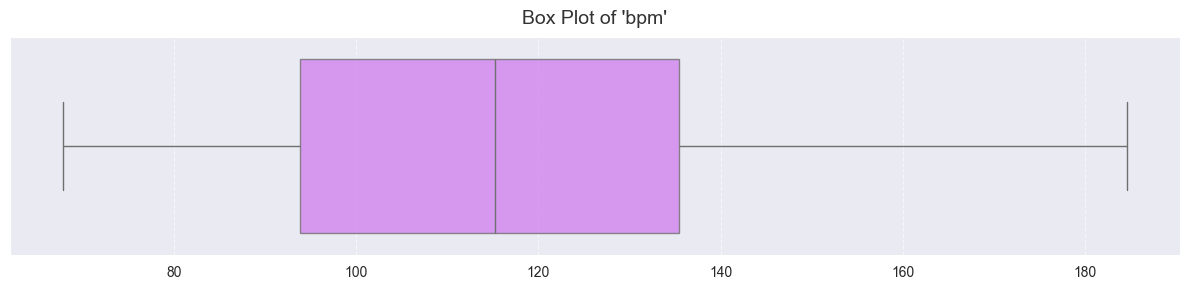

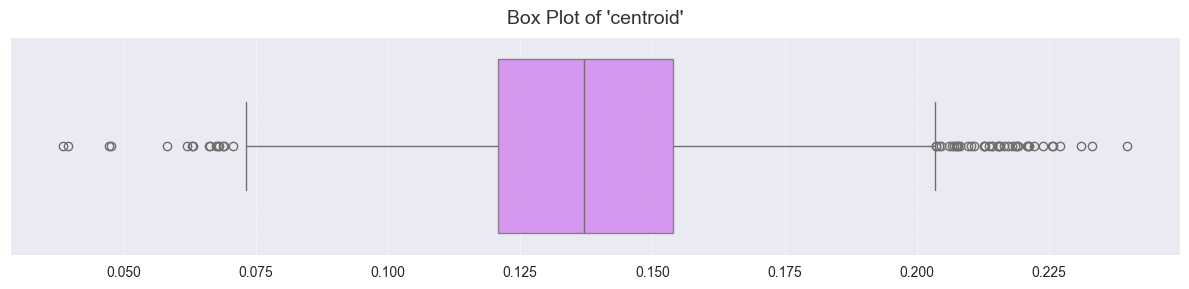

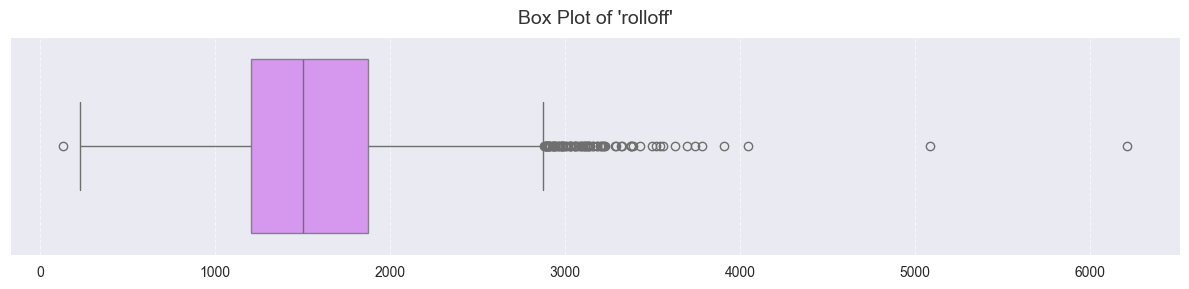

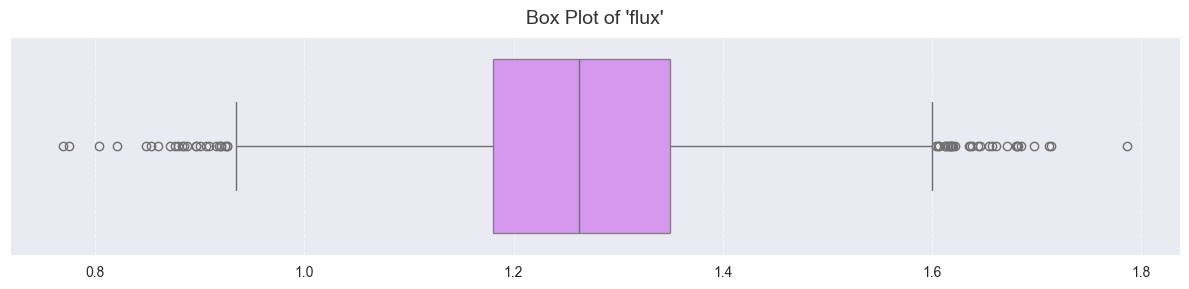

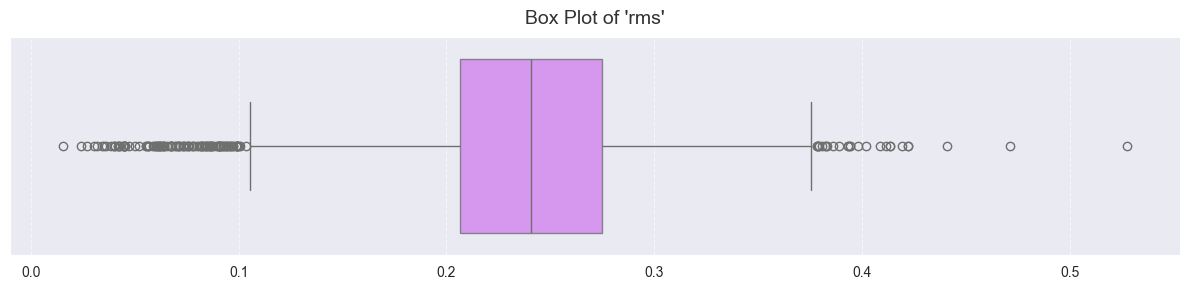

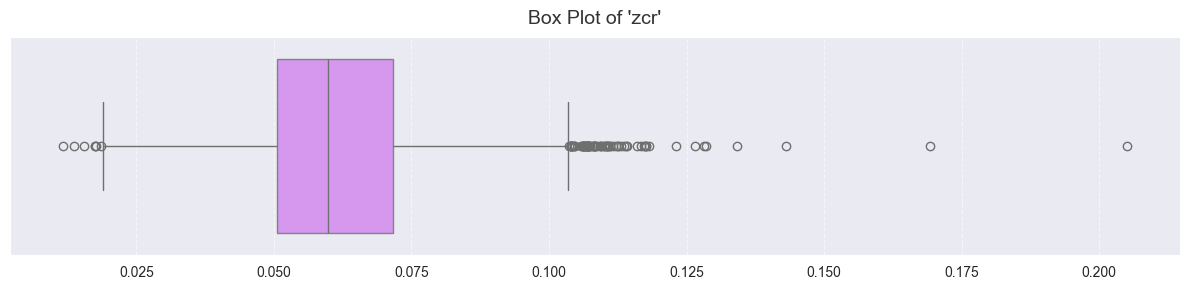

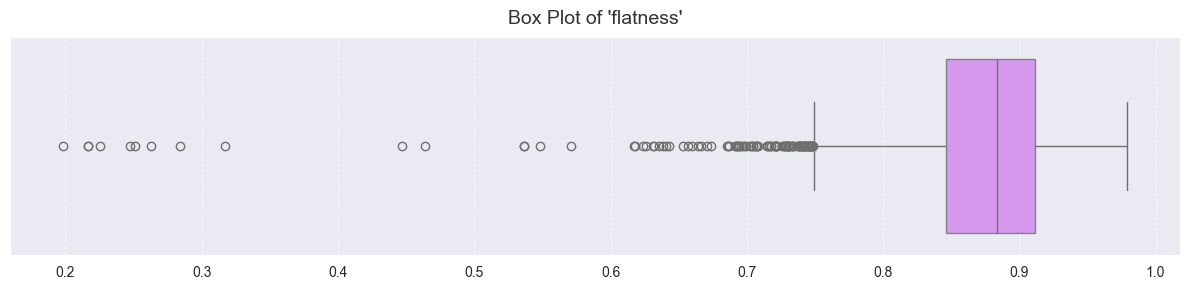

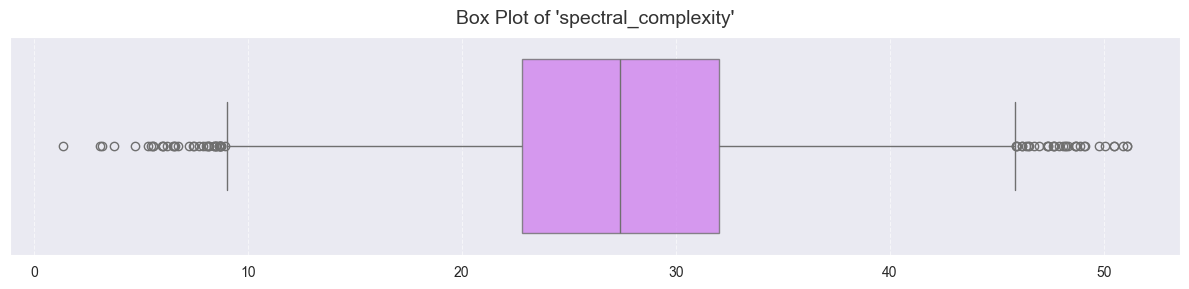

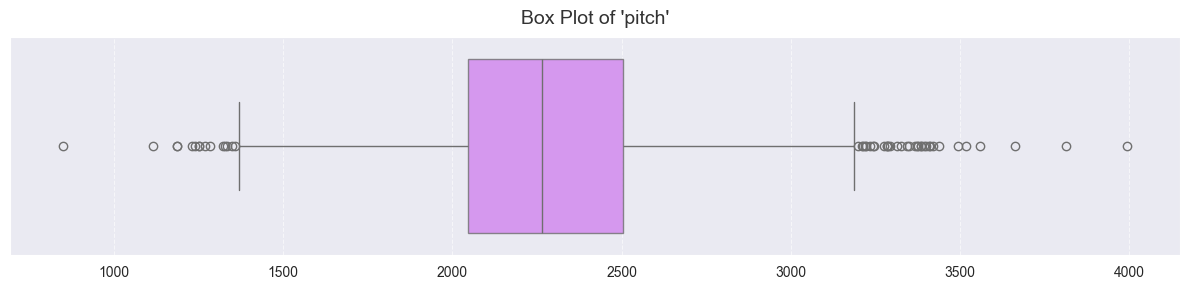

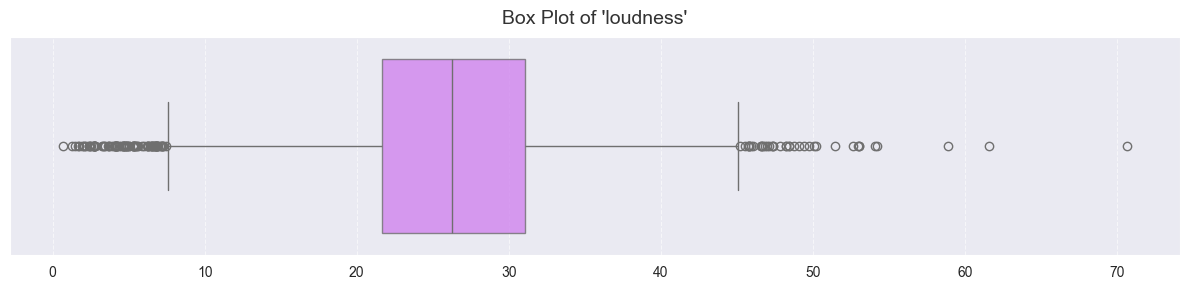

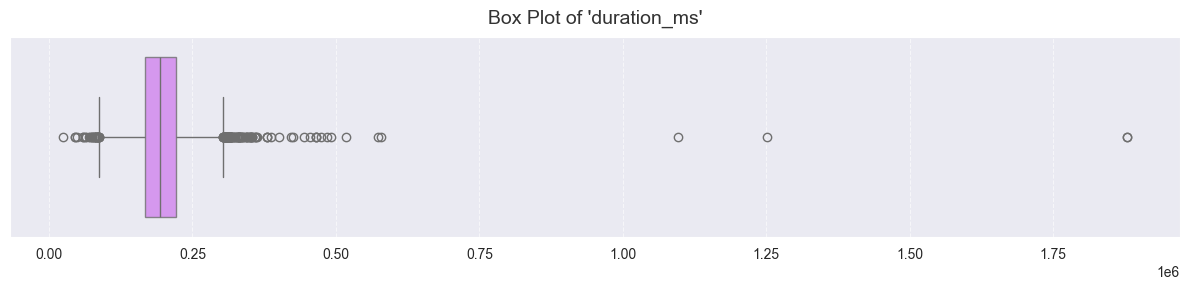

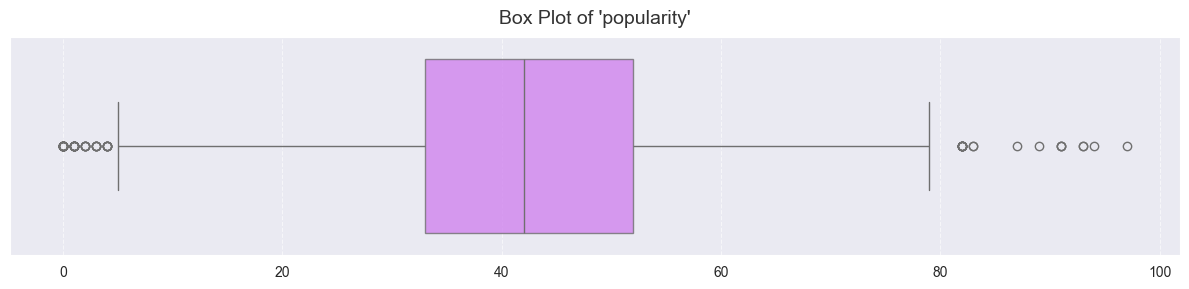

In [32]:
# Custom color palette (soft to vivid magenta)
box_color = "#D873FF"  # tono principale coerente con le altre mappe

for col in numerical_features:
    plt.figure(figsize=(12, 3))
    sns.boxplot(
        data=df_clean, 
        x=col, 
        color=box_color,
        boxprops=dict(alpha=0.8)
    )
    plt.title(f"Box Plot of '{col}'", fontsize=14, color="#333333", pad=10)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

In [33]:
# Statistical Analysis

outlier_report = []

for col in numerical_features:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    count_low = df_clean[df_clean[col] < lower_bound].shape[0]
    count_high = df_clean[df_clean[col] > upper_bound].shape[0]
    total_count = df_clean[col].count()

    if total_count > 0:
        total_perc = (count_low + count_high) / total_count * 100
    else:
        total_perc = 0

    outlier_report.append({
        'feature': col,
        'lower_bound': round(lower_bound, 2),
        'upper_bound': round(upper_bound, 2),
        'outliers_low': count_low,
        'outliers_high': count_high,
        'total_outliers': count_low + count_high,
        'total_perc': round(total_perc, 2)
    })

# Print the report
outlier_df = pd.DataFrame(outlier_report).set_index('feature')
print(outlier_df.sort_values(by='total_perc', ascending=False))

                      lower_bound  upper_bound  outliers_low  outliers_high  \
feature                                                                       
stats_pageviews         -38967.00     90661.00             0            414   
swear_EN                    -1.50         2.50             0            410   
avg_token_per_clause         2.64        11.78             1            206   
swear_IT                    -6.00        10.00             0            175   
lexical_density              0.40         0.63            60             92   
rms                          0.10         0.38           115             27   
duration_ms              87107.25    302821.25            28            107   
loudness                     7.56        45.17            94             39   
char_per_tok                 3.44         4.56            45             82   
flatness                     0.75         1.01           113              0   
n_sentences                 13.50       113.50      

Found 20 features with outliers.


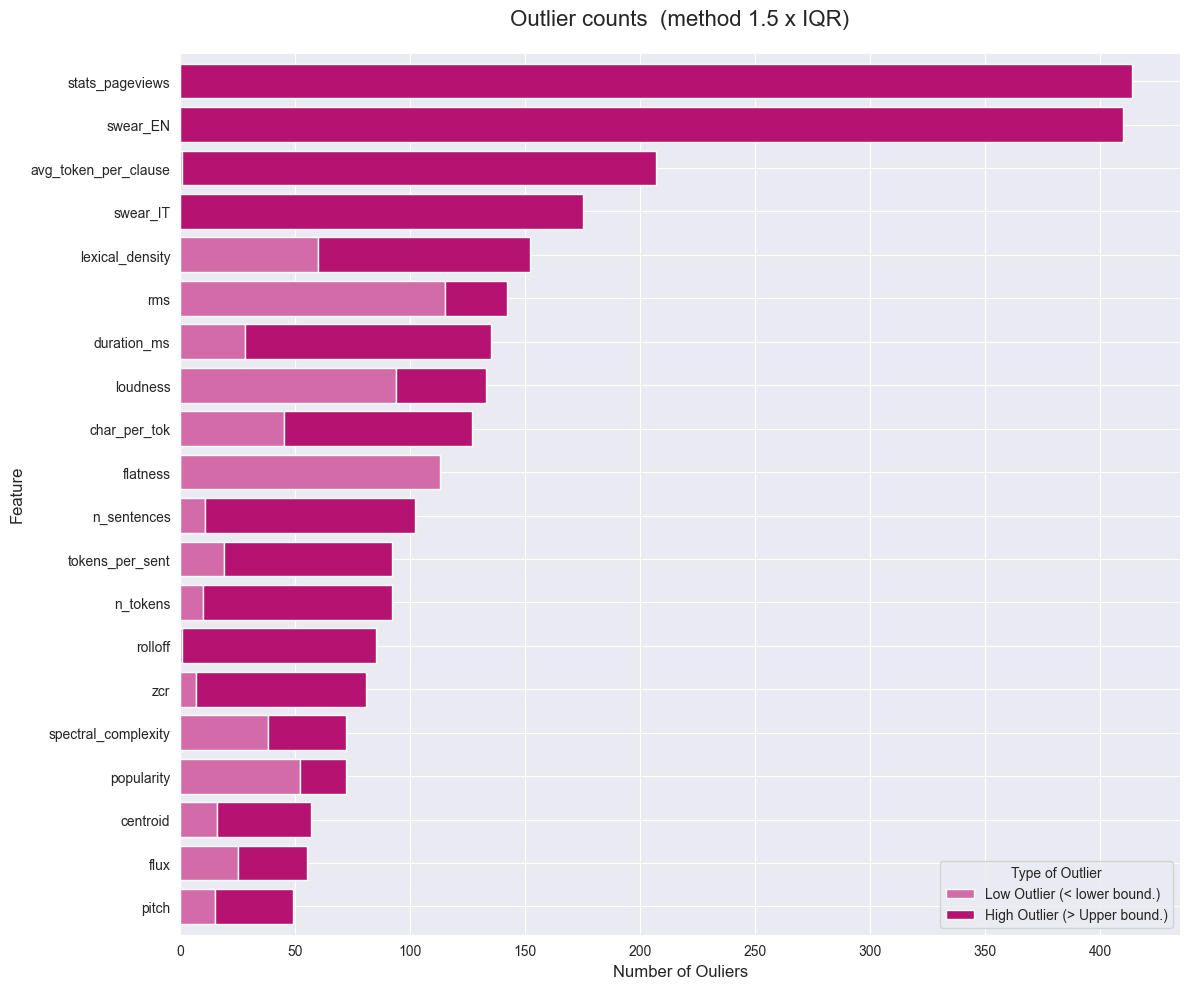

In [34]:
# Filtering and plotting outlier data
plot_data = outlier_df[outlier_df['total_outliers'] > 0]

# Sort the number of outliers in descending order
plot_data = plot_data.sort_values(by='total_outliers', ascending=False)
plot_data = plot_data[['outliers_low', 'outliers_high']]

print(f"Found {len(plot_data)} features with outliers.")

if plot_data.empty:
    print("No outliers to plot.")
else:

    colors = ['#d36ba8', '#b51272']

    ax = plot_data.plot(
        kind='barh',
        stacked=True,
        figsize=(12, 10),
        color=colors,
        width=0.8
    )

    plt.title('Outlier counts  (method 1.5 x IQR)', fontsize=16, pad=20)
    plt.xlabel('Number of Ouliers', fontsize=12) # 'Ouliers' è probabilmente un refuso per 'Outliers'
    plt.ylabel('Feature', fontsize=12)

    plt.gca().invert_yaxis()

    plt.legend(
        title='Type of Outlier',
        labels=['Low Outlier (< lower bound.)', 'High Outlier (> Upper bound.)'],
        loc='lower right'
    )

    plt.tight_layout()
    plt.show()

1. Skewed Features (Needing Log-Transform): The report shows that features like stats_pageviews (8.93% outliers) and swear_EN (8.85%) are not normally distributed; they are highly skewed. The box plots (e.g., image_ce5d57.png for stats_pageviews) visually confirm this, showing the data is "squashed" to one side with a long tail of outliers. These are perfect candidates for Strategy 1: Log Transformation.

2. Other Outliers (Needing Clipping): The rest of the features (like avg_token_per_clause, lexical_density, loudness, etc.) have a smaller, more manageable percentage of outliers (mostly 1-4%). These represent legitimate but extreme values. They are ideal for Strategy 2: Clipping, which will reduce their influence without deleting them.

In [35]:
# Trasformazione Log

skewed_cols = [
    'stats_pageviews',
    'swear_EN',
    'avg_token_per_clause',
    'swear_IT',
    'rms',
    'duration_ms',
    'n_sentences',
    'n_tokens',
    'rolloff',
    'zcr'
]

for col in skewed_cols:
    if col in df_clean.columns:
        new_col_name = f"{col}_log"
        df_clean[new_col_name] = np.log1p(df_clean[col])
        print(f"'{new_col_name}' Column created.")


'stats_pageviews_log' Column created.
'swear_EN_log' Column created.
'avg_token_per_clause_log' Column created.
'swear_IT_log' Column created.
'rms_log' Column created.
'duration_ms_log' Column created.
'n_sentences_log' Column created.
'n_tokens_log' Column created.
'rolloff_log' Column created.
'zcr_log' Column created.


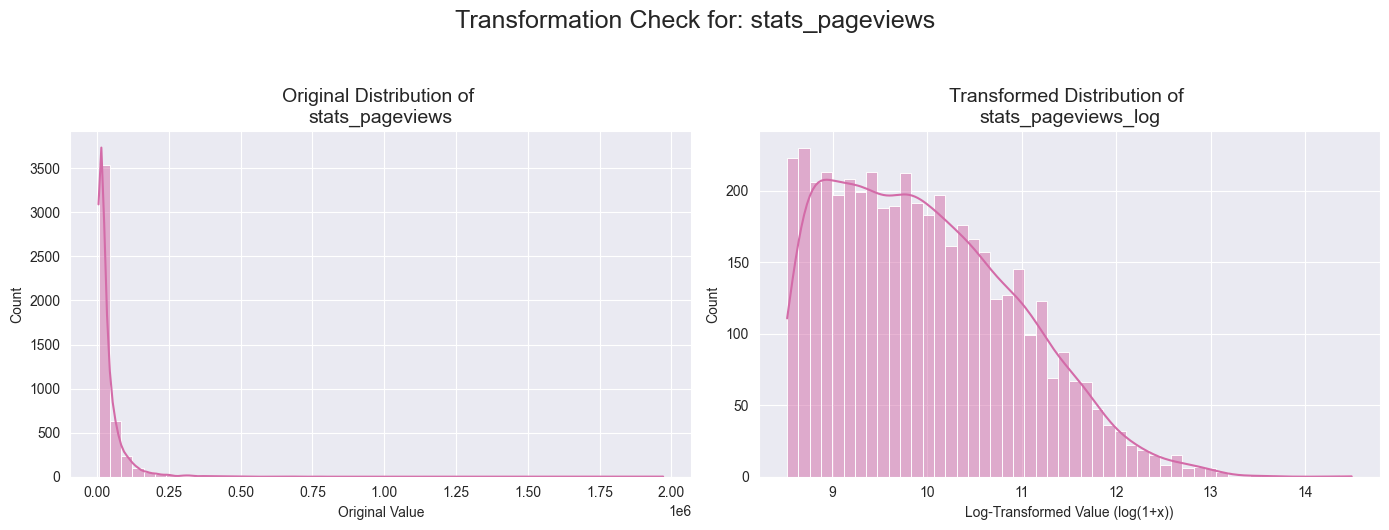

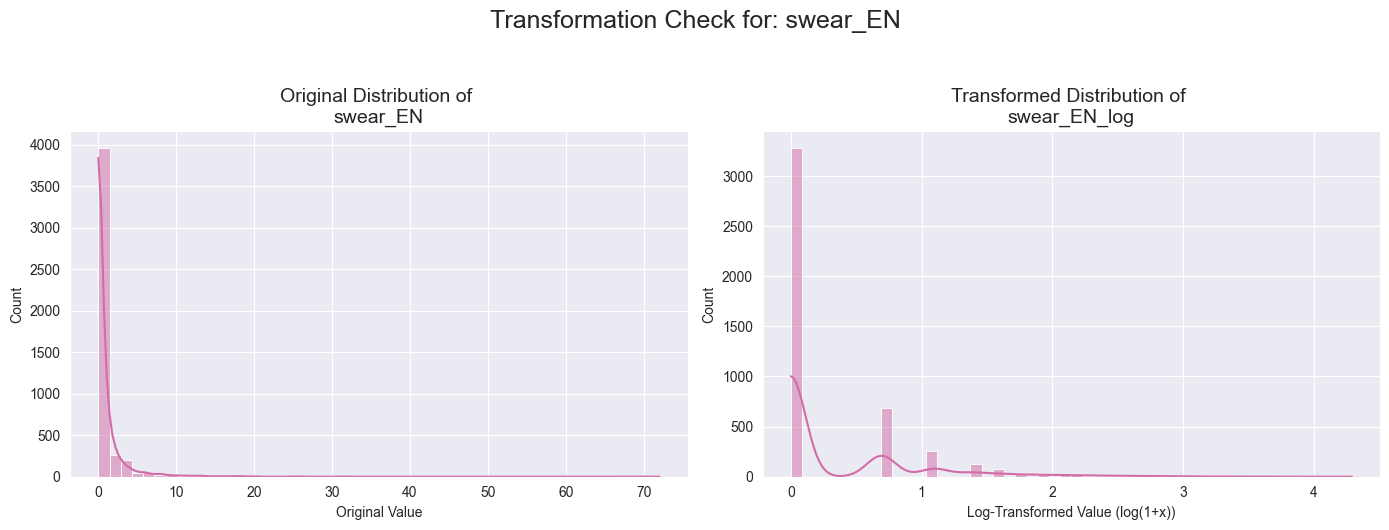

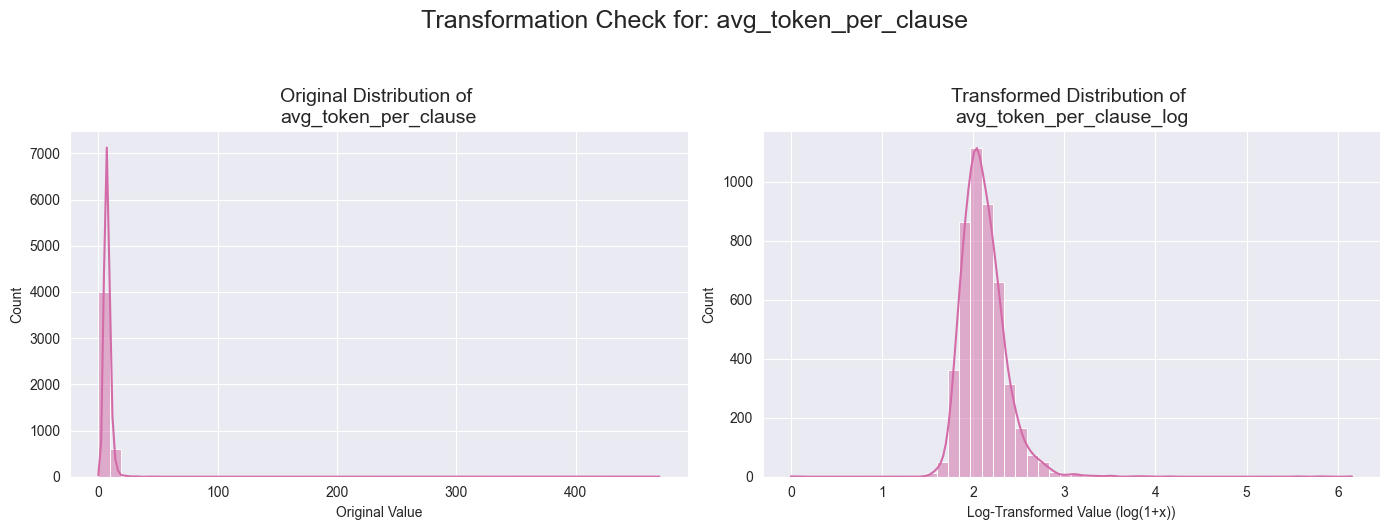

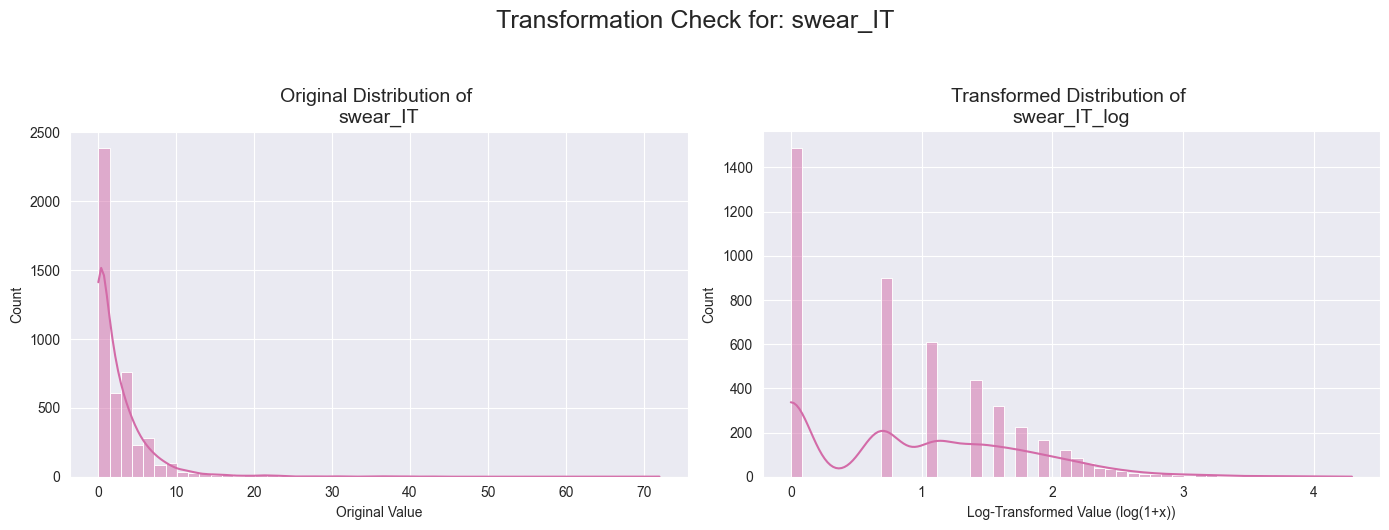

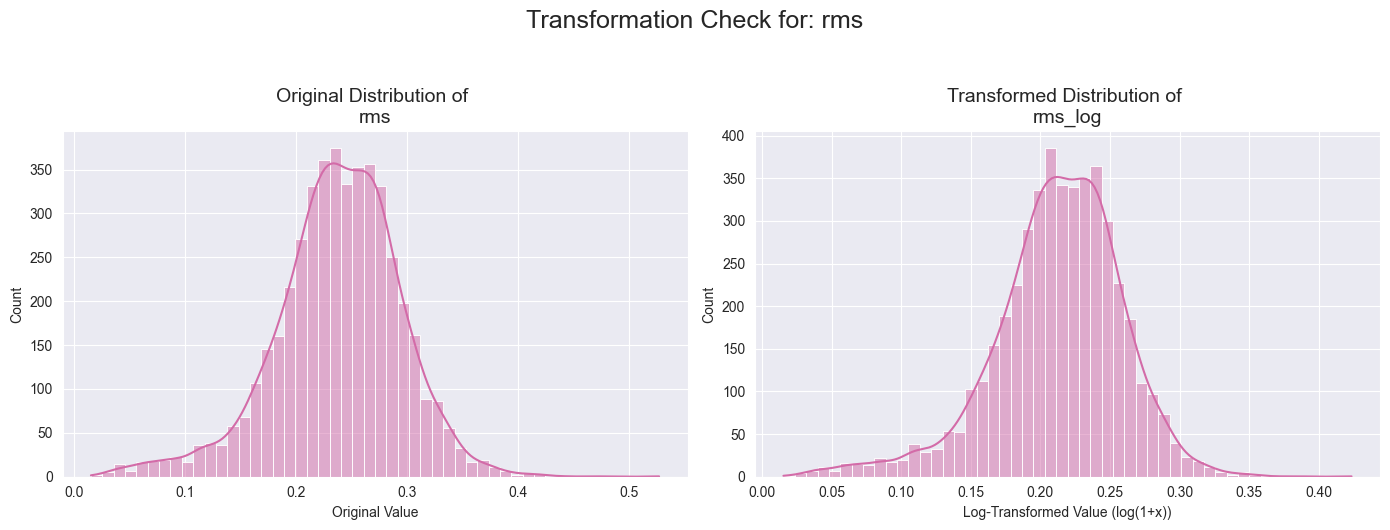

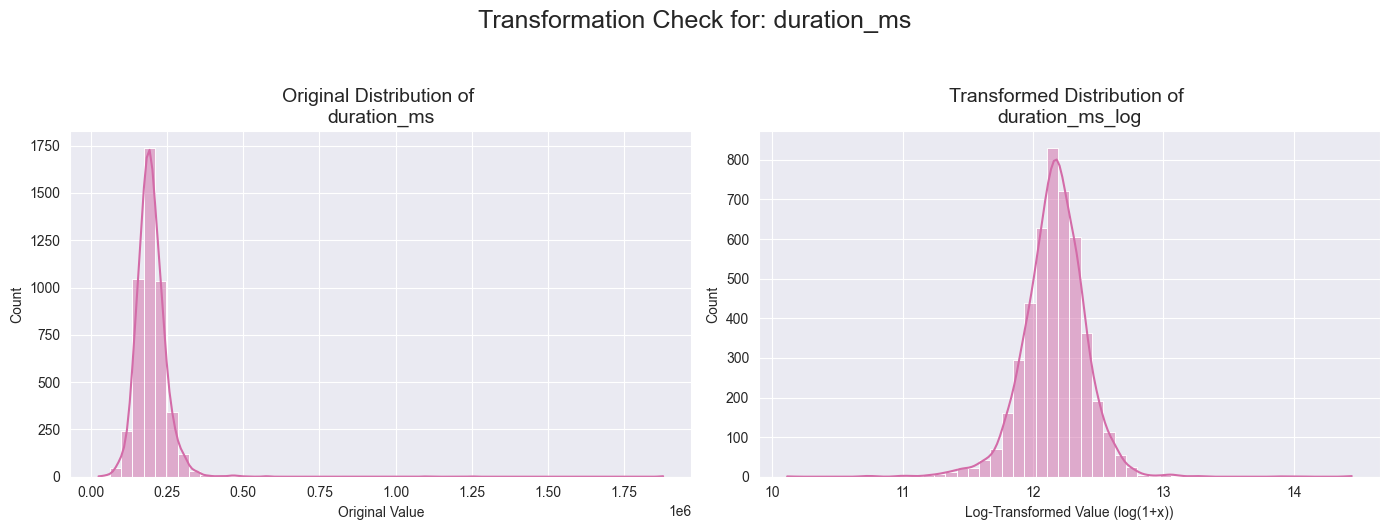

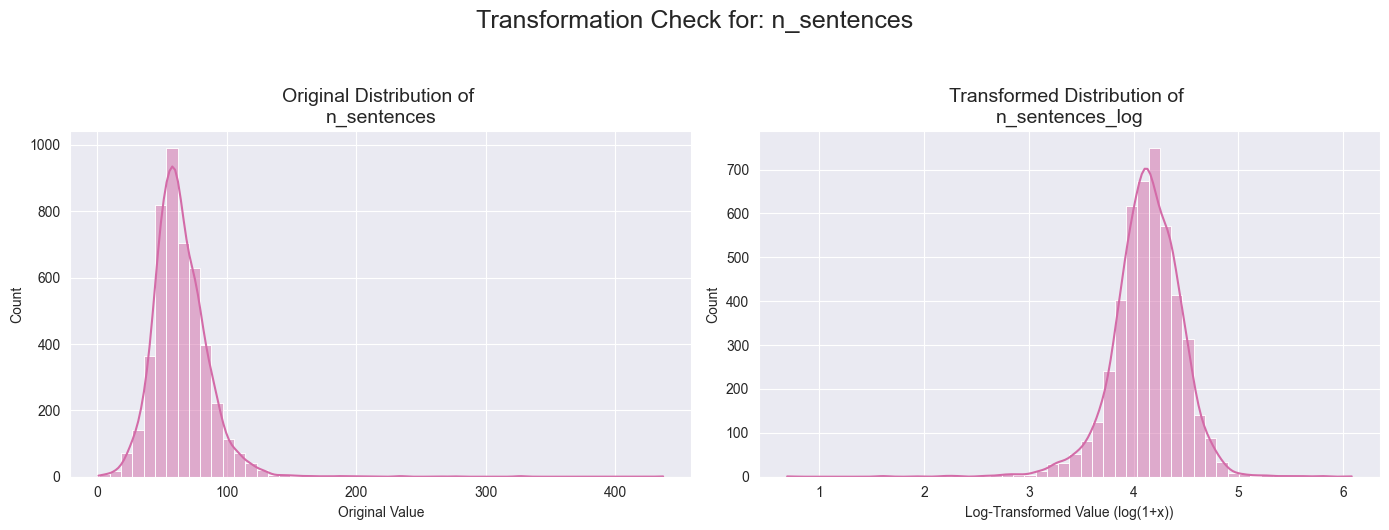

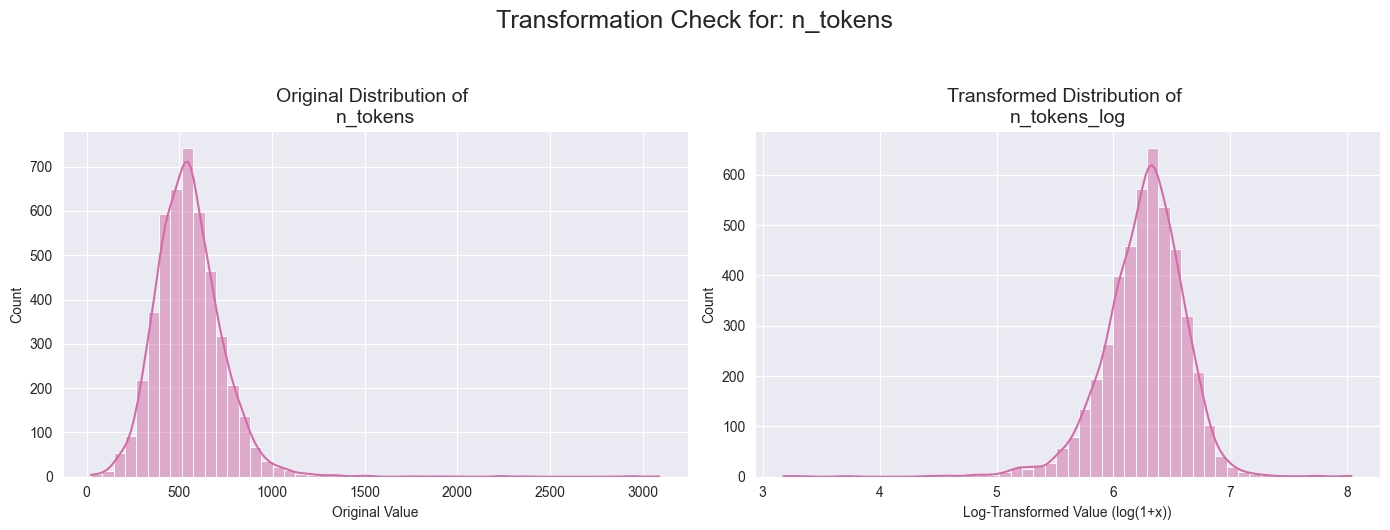

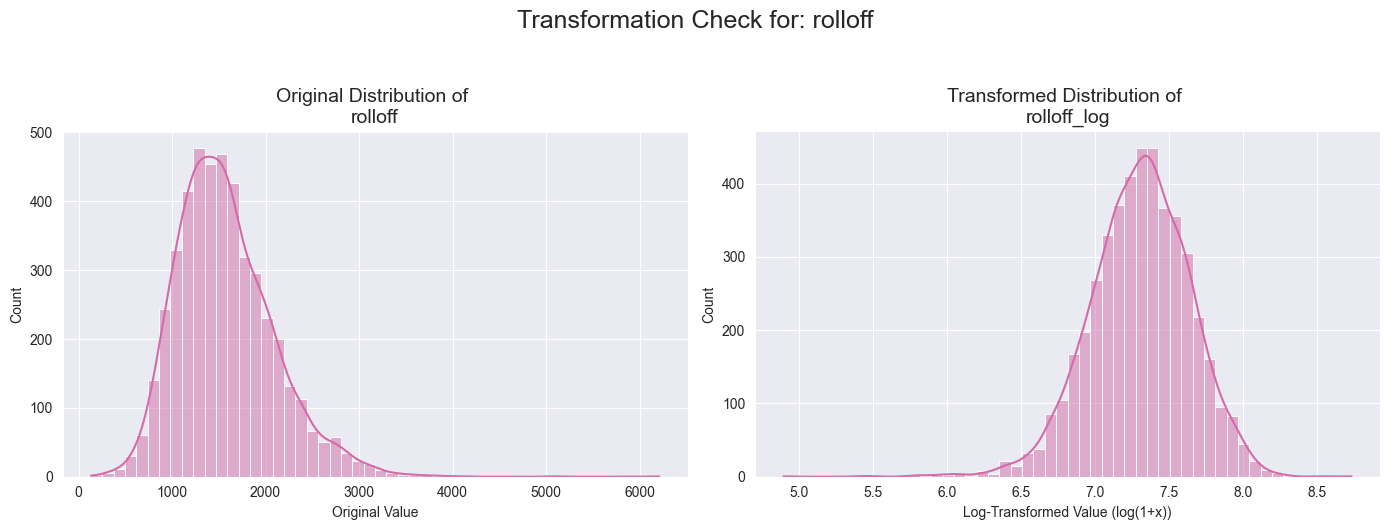

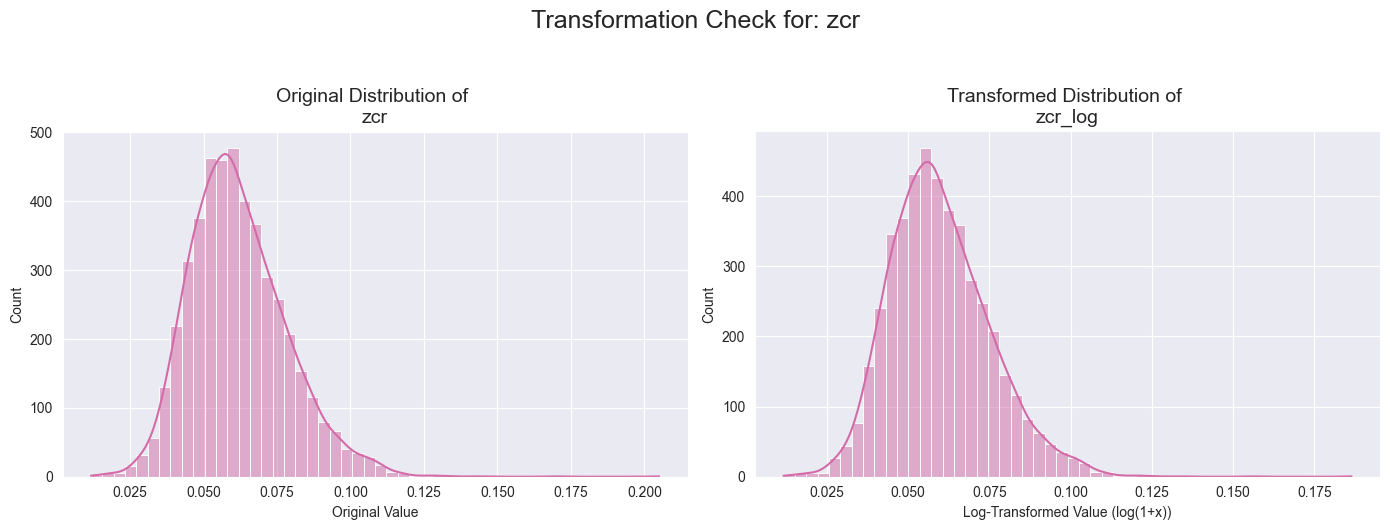

In [36]:
# Visual Check of Transformation
for col in skewed_cols:
    col_log = f"{col}_log"

    if col in df_clean.columns and col_log in df_clean.columns:

        plt.figure(figsize=(14, 5))

        # --- Plot 1: Original Distribution ---
        plt.subplot(1, 2, 1)
        sns.histplot(df_clean[col], kde=True, bins=50, color='#d36ba8')
        plt.title(f'Original Distribution of \n{col}', fontsize=14)
        plt.xlabel('Original Value')
        plt.ylabel('Count')

        # --- Plot 2: Transformed Distribution ---
        plt.subplot(1, 2, 2)
        sns.histplot(df_clean[col_log], kde=True, bins=50, color='#d36ba8')
        plt.title(f'Transformed Distribution of \n{col_log}', fontsize=14) #
        plt.xlabel('Log-Transformed Value (log(1+x))')
        plt.ylabel('Count')


        plt.suptitle(f'Transformation Check for: {col}', fontsize=18, y=1.05)
        plt.tight_layout()
        plt.show()

In [37]:
# Clipping

clipping_cols = [col for col in numerical_features if col not in skewed_cols]

for col in clipping_cols:
    if col in df_clean.columns:

        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        count_low = (df_clean[col] < lower_bound).sum()
        count_high = (df_clean[col] > upper_bound).sum()


        if (count_low + count_high) > 0:
            df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
            print(f"Clipping applied to '{col}': {count_low+count_high} values clipped.")

Clipping applied to 'tokens_per_sent': 92 values clipped.
Clipping applied to 'char_per_tok': 127 values clipped.
Clipping applied to 'lexical_density': 152 values clipped.
Clipping applied to 'centroid': 57 values clipped.
Clipping applied to 'flux': 55 values clipped.
Clipping applied to 'flatness': 113 values clipped.
Clipping applied to 'spectral_complexity': 72 values clipped.
Clipping applied to 'pitch': 49 values clipped.
Clipping applied to 'loudness': 133 values clipped.
Clipping applied to 'popularity': 72 values clipped.


In [38]:
# Final Check After Outlier Handling

transformed_cols = [f"{col}_log" for col in skewed_cols]

# Combine the lists for the final check
final_feature_list = transformed_cols + clipping_cols

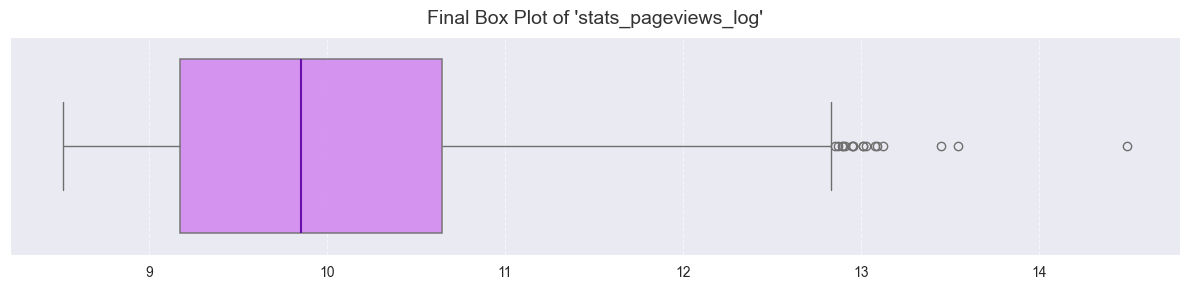

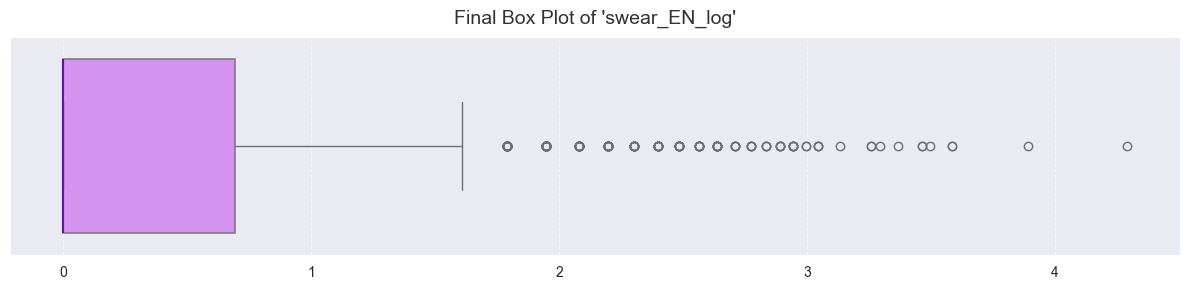

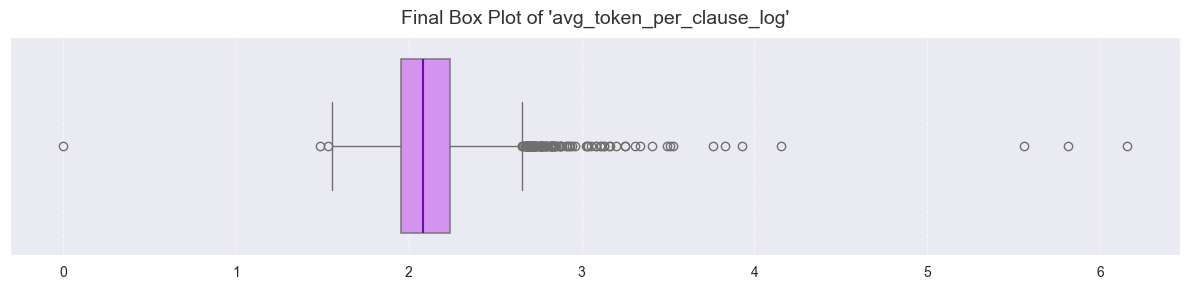

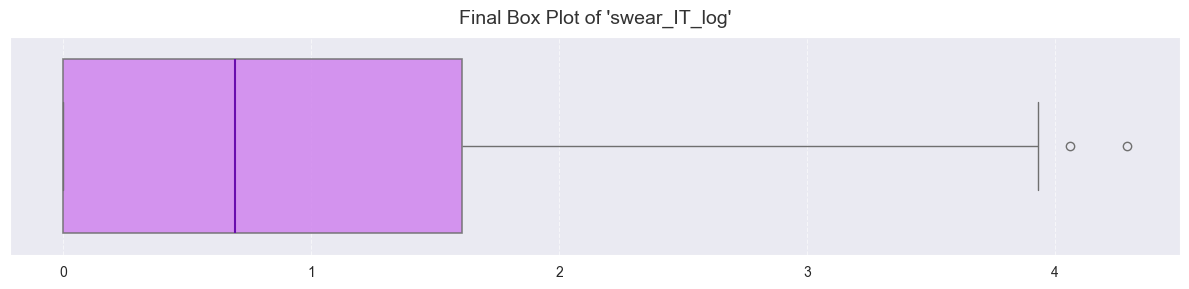

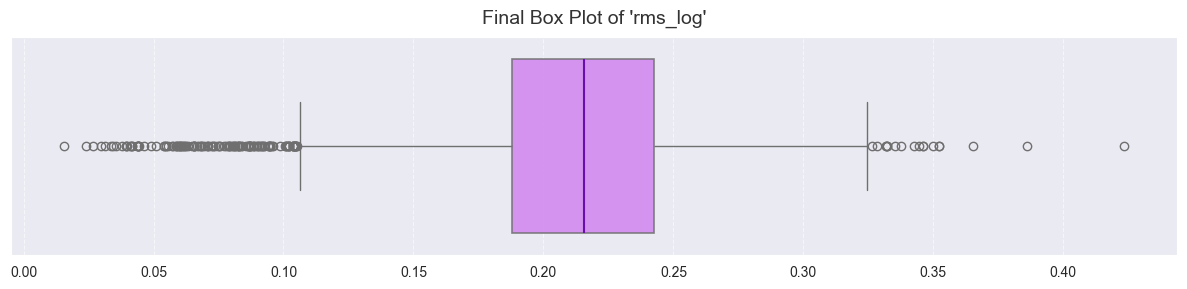

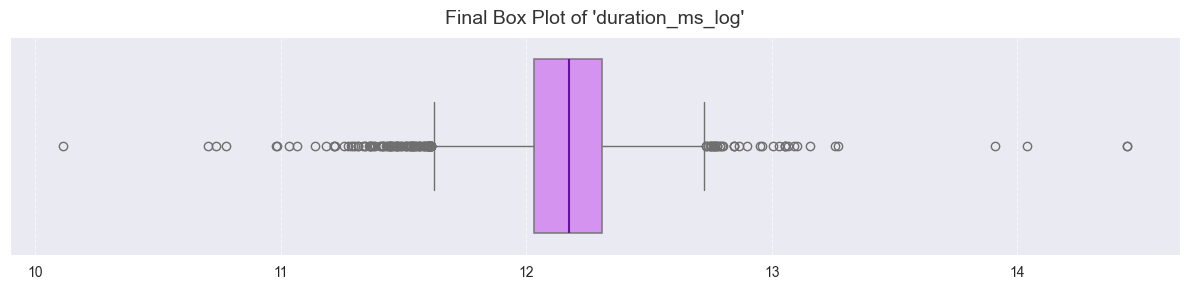

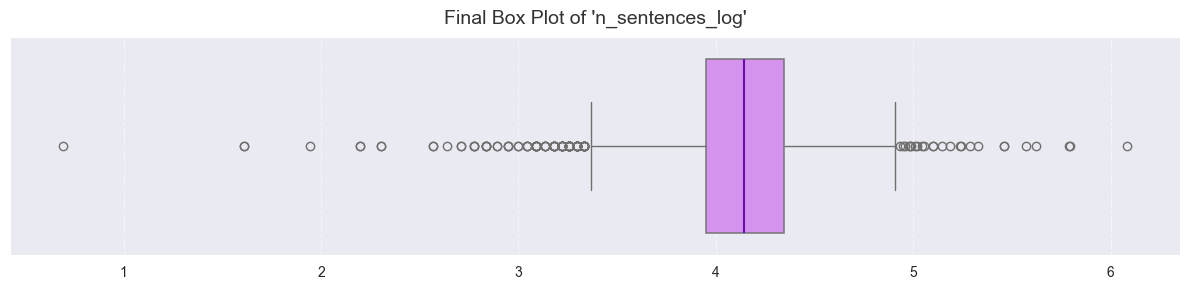

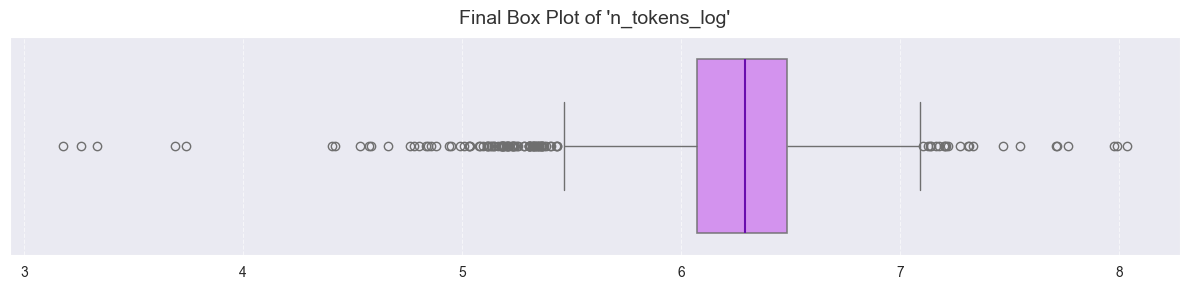

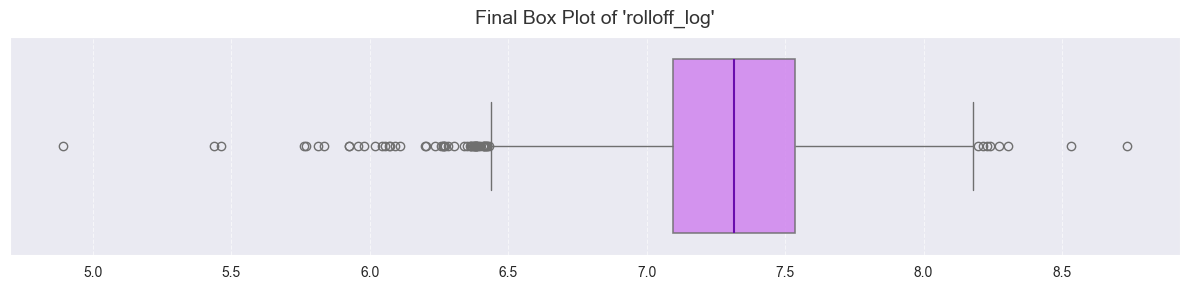

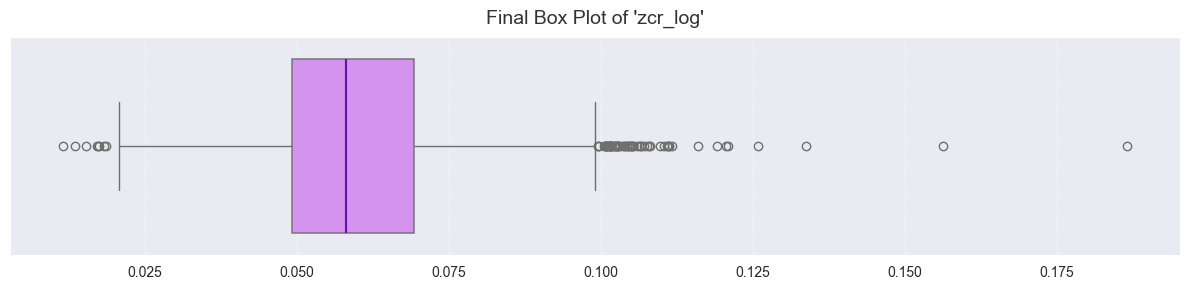

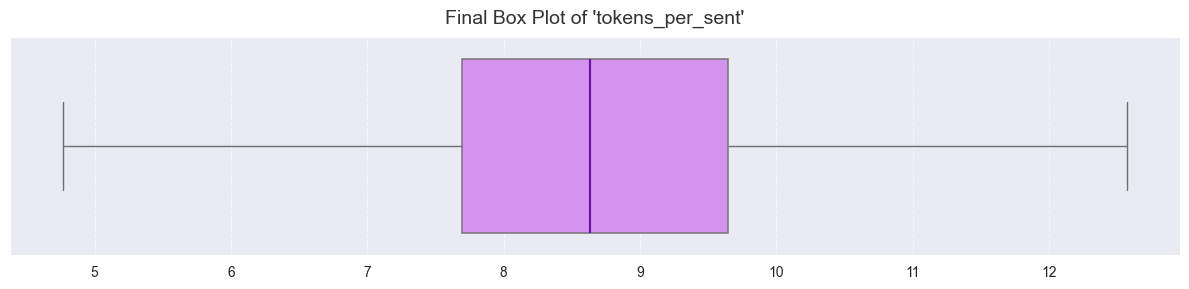

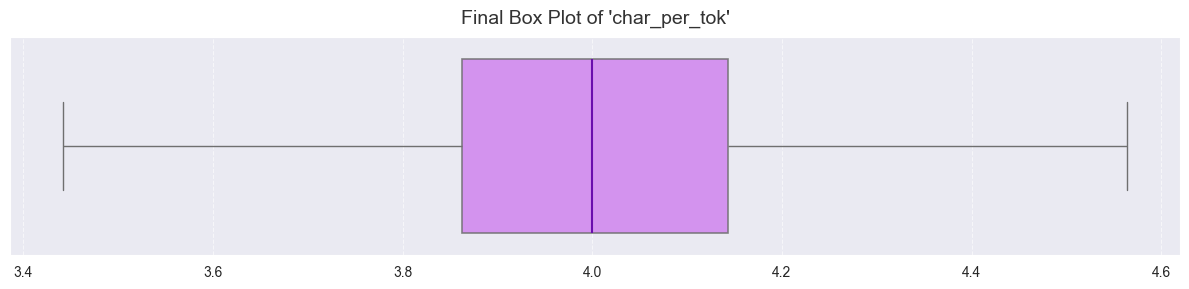

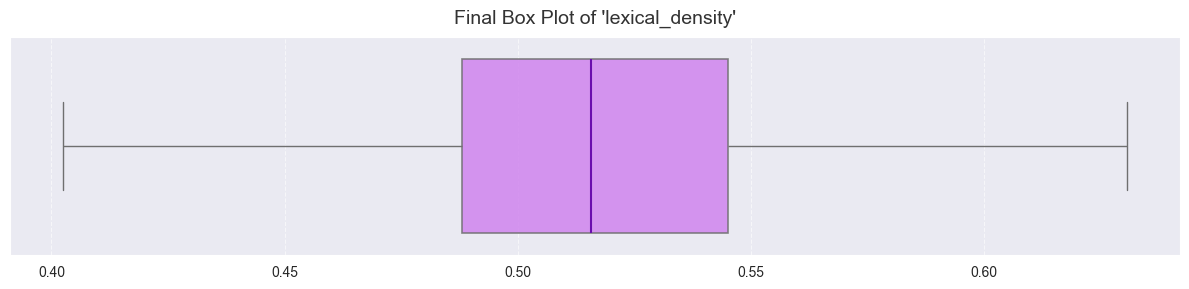

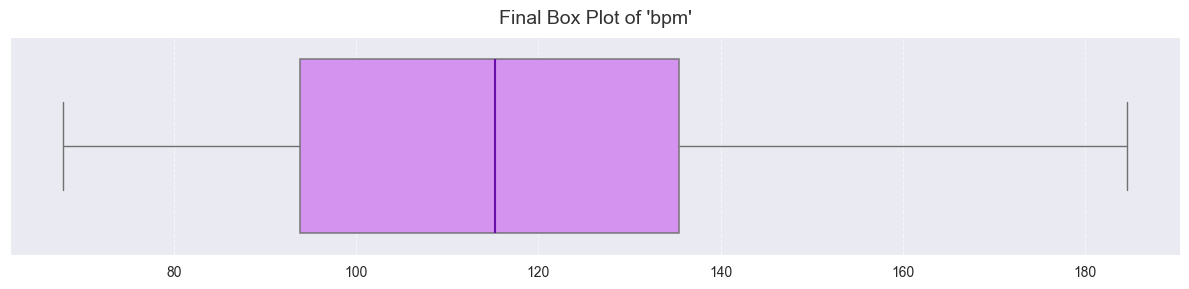

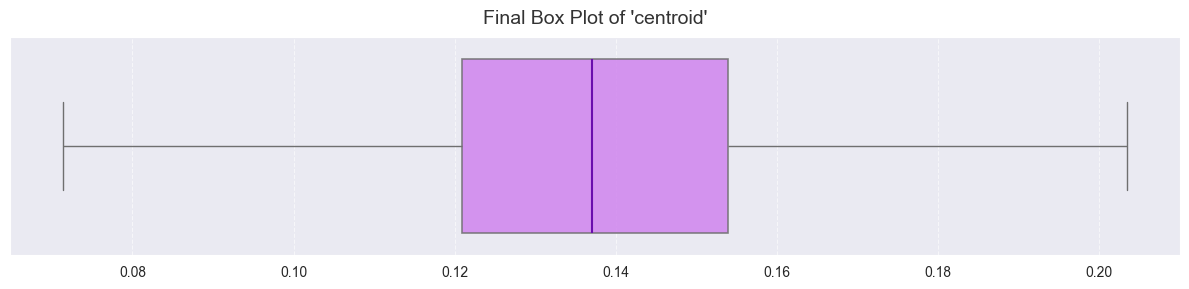

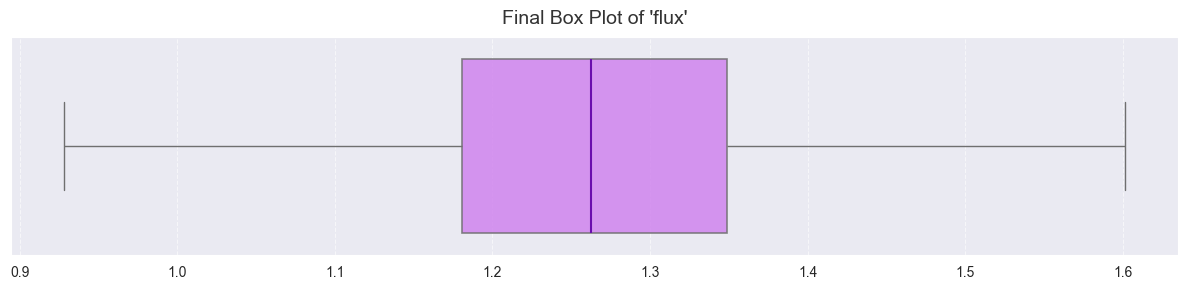

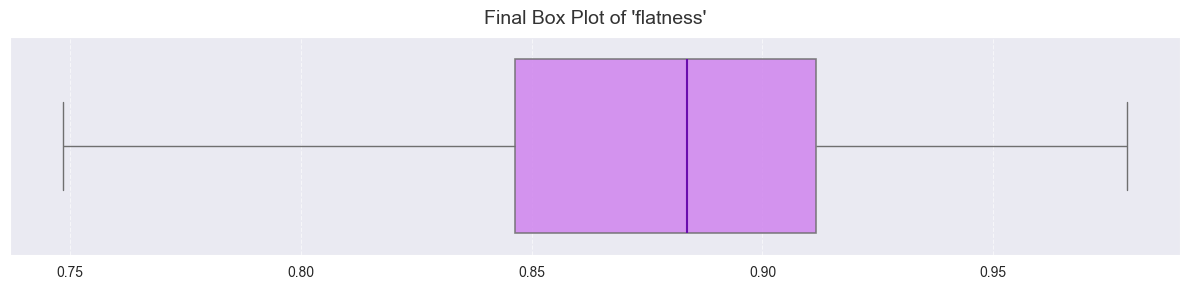

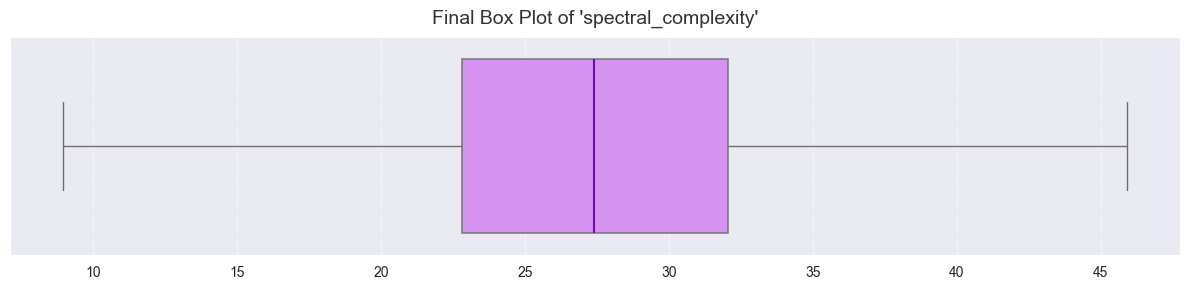

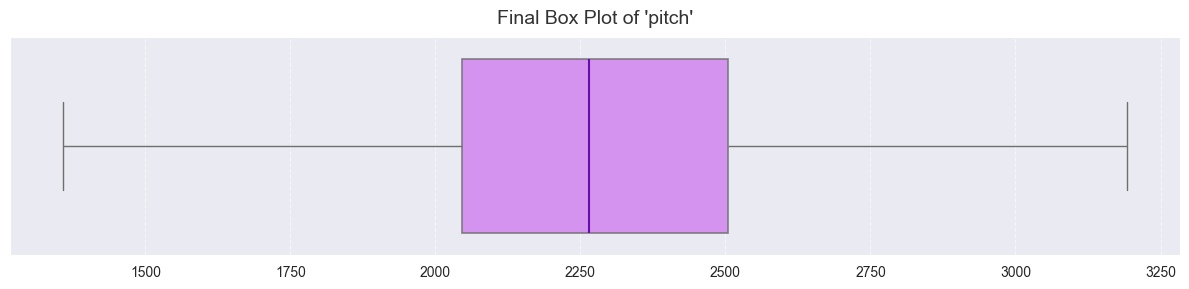

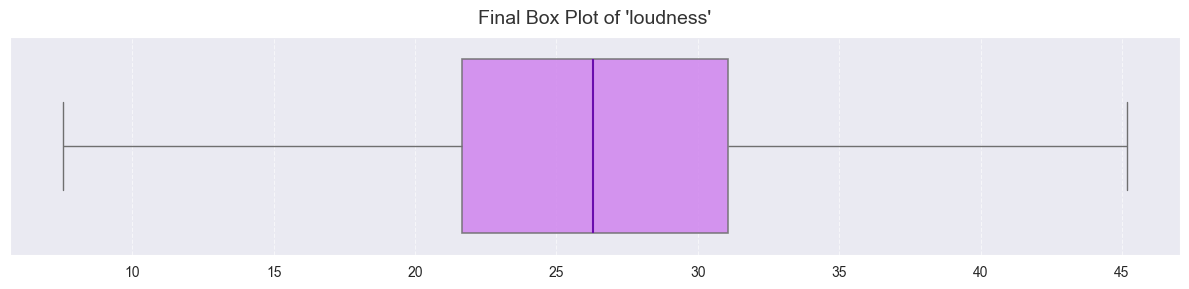

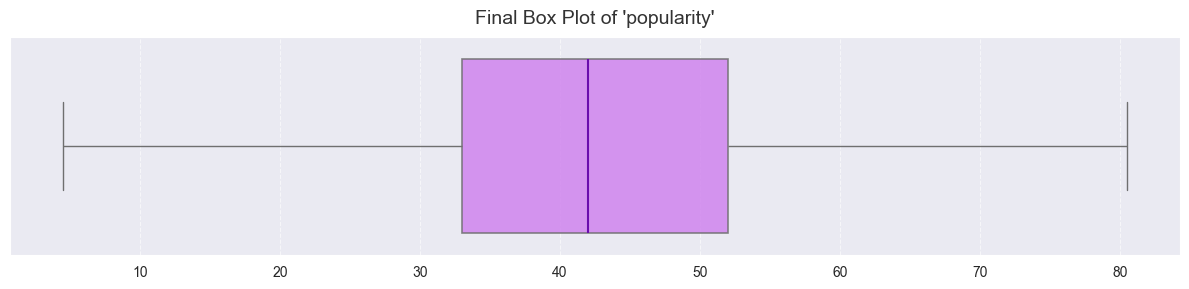

In [39]:
box_color = "#D873FF"  # lavanda/magenta intermedio

for col in final_feature_list:
    if col in df_clean.columns:
        plt.figure(figsize=(12, 3))
        sns.boxplot(
            data=df_clean,
            x=col,
            color=box_color,
            boxprops=dict(alpha=0.85, linewidth=1.2),
            medianprops=dict(color="#6A0DAD", linewidth=1.5)
        )
        plt.title(f"Final Box Plot of '{col}'", fontsize=14, color="#333333", pad=10)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.xlabel("")
        plt.tight_layout()
        plt.show()

In [40]:
# Statistical Check (Final IQR Report)

final_outlier_report = []

for col in final_feature_list:
    if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col]):

        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        count_low = (df_clean[col] < lower_bound).sum()
        count_high = (df_clean[col] > upper_bound).sum()

        total_count = df_clean[col].count()

        if total_count > 0:
            total_perc = (count_low + count_high) / total_count * 100
        else:
            total_perc = 0

        final_outlier_report.append({
            'feature': col,
            'lower_bound': round(lower_bound, 2),
            'upper_bound': round(upper_bound, 2),
            'outliers_low': count_low,
            'outliers_high': count_high,
            'total_outliers': count_low + count_high,
            'total_perc': round(total_perc, 2)
        })

# Print the final report
if final_outlier_report:
    final_outlier_df = pd.DataFrame(final_outlier_report).set_index('feature')
    print(final_outlier_df.sort_values(by='total_perc', ascending=False))

                          lower_bound  upper_bound  outliers_low  \
feature                                                            
swear_EN_log                    -1.04         1.73             0   
rms_log                          0.11         0.33           135   
duration_ms_log                 11.61        12.73            94   
n_sentences_log                  3.36         4.93            96   
avg_token_per_clause_log         1.54         2.66             3   
n_tokens_log                     5.45         7.10            91   
zcr_log                          0.02         0.10             8   
rolloff_log                      6.44         8.20            51   
stats_pageviews_log              6.97        12.86             0   
swear_IT_log                    -2.41         4.02             0   
tokens_per_sent                  4.77        12.57             0   
char_per_tok                     3.44         4.56             0   
lexical_density                  0.40         0.

Found 10 features with outliers.


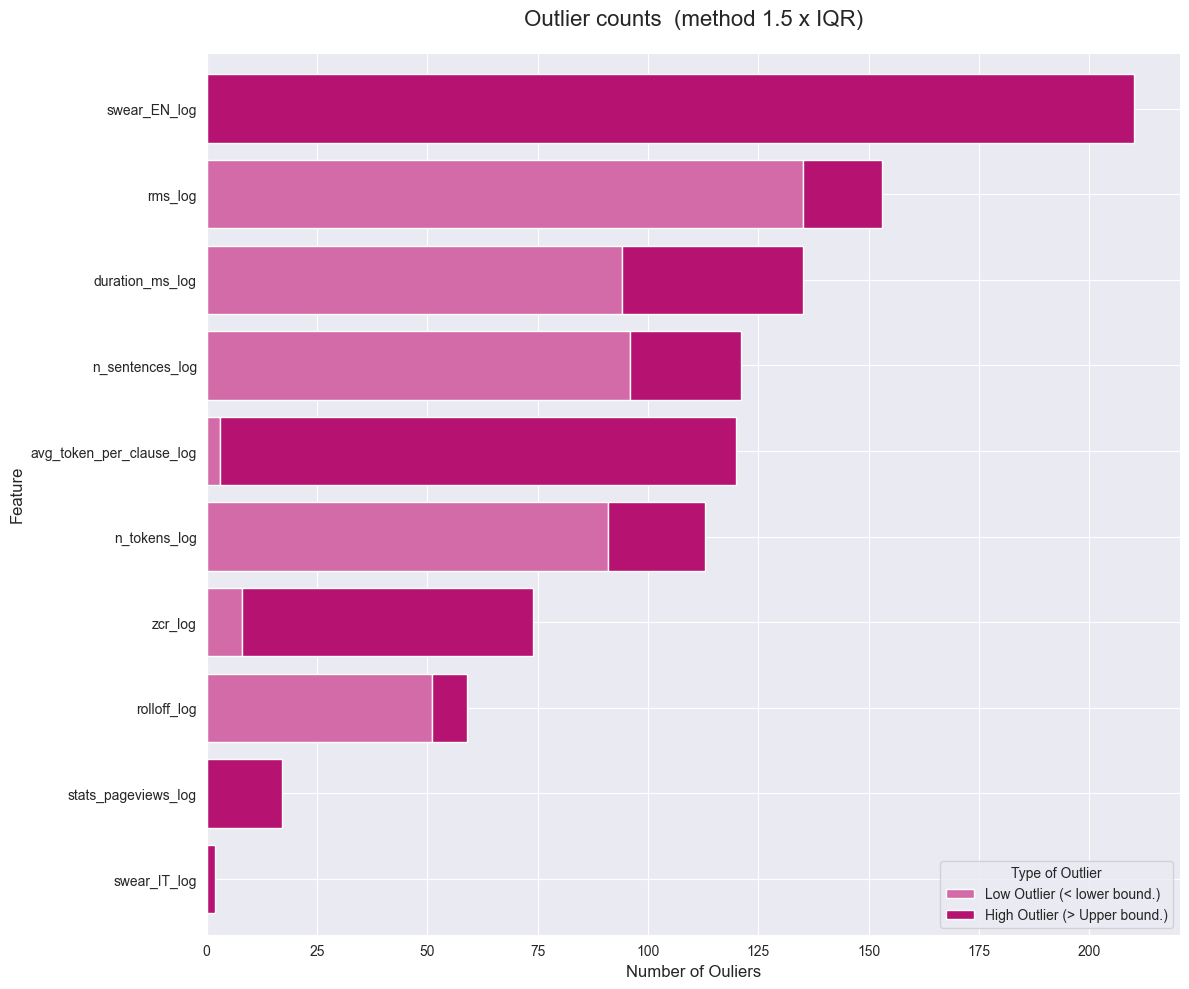

In [41]:
# Filtering and plotting outlier data
plot_data = final_outlier_df[final_outlier_df['total_outliers'] > 0]

# Sort the number of outliers in descending order
plot_data = plot_data.sort_values(by='total_outliers', ascending=False)
plot_data = plot_data[['outliers_low', 'outliers_high']]

print(f"Found {len(plot_data)} features with outliers.")

if plot_data.empty:
    print("No outliers to plot.")
else:

    colors = ['#d36ba8', '#b51272']

    ax = plot_data.plot(
        kind='barh',
        stacked=True,
        figsize=(12, 10),
        color=colors,
        width=0.8
    )

    plt.title('Outlier counts  (method 1.5 x IQR)', fontsize=16, pad=20)
    plt.xlabel('Number of Ouliers', fontsize=12)
    plt.ylabel('Feature', fontsize=12)

    plt.gca().invert_yaxis()

    plt.legend(
        title='Type of Outlier',
        labels=['Low Outlier (< lower bound.)', 'High Outlier (> Upper bound.)'],
        loc='lower right'
    )

    plt.tight_layout()
    plt.show()

1. "Zero-Inflated" Features (Statistical Artifact)
Most of the data is 0. This means Q1=0 and Q3=0, so the IQR is 0. The statistical rule Q3 + (1.5 * IQR) calculates an upper bound of 0.
The rule is "broken" for this data. It flags every non-zero value as an outlier, even after transformation.

2. "Natural Tails" of a New Bell-Curve
Example: n_sentences_log (711 outliers), n_tokens_log (634), stats_pageviews_log (17)
The log transform successfully changed these skewed distributions into a symmetrical, "bell-shaped" (normal) distribution, as seen in your histograms.
The 1.5 * IQR rule is very strict. The outliers it now finds are not errors; they are simply the natural tails of the new, healthy bell-curve.

## Data Quality

### Logical and Temporal Analysis on `artists.csv`

This phase checks internal consistency within the artists dataset.  
We verify:
- temporal coherence between birth and active years  
- geographic coherence (regions with missing coordinates)  
- semantic duplicates (same name, different IDs)  
- nationality vs country mismatches

In [42]:
artists["birth_date"] = pd.to_datetime(artists["birth_date"], errors="coerce").dt.year
artists["active_start"] = pd.to_datetime(artists["active_start"], errors="coerce").dt.year
artists["active_end"] = pd.to_datetime(artists["active_end"], errors="coerce").dt.year


# 1. Inconsistent activity period
invalid_period = artists[
    (artists["active_start"].notna()) &
    (artists["active_end"].notna()) &
    (artists["active_end"] < artists["active_start"])
]

# 2. Artists active before age 10
invalid_age = artists[
    (artists["birth_date"].notna()) &
    (artists["active_start"].notna()) &
    (artists["active_start"] - artists["birth_date"] < 10)
]

# 3. Artists with regional info but missing coordinates
geo_inconsistent = artists[
    (artists[["province", "region", "country"]].notna().any(axis=1)) &
    (artists[["latitude", "longitude"]].isna().any(axis=1))
]

# 4. Nationality vs country mismatch
nationality_mismatch = artists[
    (artists["nationality"].notna()) & (artists["country"].notna()) &
    (artists["nationality"].str.lower() != artists["country"].str.lower())
]

# 5. Duplicate artist names
duplicate_names = artists[artists.duplicated(subset=["name"], keep=False)].sort_values("name")

print(f"Inconsistent activity period: {len(invalid_period)}")
print(f"Artists active before age 10: {len(invalid_age)}")
print(f"Artists with incomplete geographic info: {len(geo_inconsistent)}")
print(f"Nationality ≠ country: {len(nationality_mismatch)}")
print(f"Duplicate artist names with different IDs: {len(duplicate_names)}")

Inconsistent activity period: 0
Artists active before age 10: 0
Artists with incomplete geographic info: 0
Nationality ≠ country: 0
Duplicate artist names with different IDs: 0


### Internal Consistency in `tracks.csv`

Here we check for logical inconsistencies in the tracks dataset:
- temporal coherence (`year` vs `album_release_date`)  
- explicit flag vs profanity count  
- modified popularity vs original popularity  
- negative or out-of-range audio features  
- partial or inconsistent date fields

In [43]:
# Convert album release date
tracks["album_release_date"] = pd.to_datetime(tracks["album_release_date"], errors="coerce")
tracks["album_year"] = tracks["album_release_date"].dt.year

# Ensure 'year' is numeric
tracks["year"] = pd.to_numeric(tracks["year"], errors="coerce")

# 1. Year mismatch between metadata and album release date (no int casting)
inconsistent_years = tracks[
    (tracks["year"].notna()) & (tracks["album_year"].notna()) &
    (tracks["year"].round(0) != tracks["album_year"].round(0))
]

# 2. Modified popularity differs from original
tracks["popularity"] = pd.to_numeric(tracks["popularity"], errors="coerce")
tracks["modified_popularity"] = pd.to_numeric(tracks["modified_popularity"], errors="coerce")

popularity_diff = tracks[tracks["popularity"] != tracks["modified_popularity"]].copy()
popularity_diff["popularity_delta"] = (
    popularity_diff["modified_popularity"] - popularity_diff["popularity"]
)

# Summary stats for popularity differences
diff_rate = len(popularity_diff) / len(tracks) * 100
mean_delta = popularity_diff["popularity_delta"].mean()
increase_ratio = (popularity_diff["popularity_delta"] > 0).mean() * 100
decrease_ratio = (popularity_diff["popularity_delta"] < 0).mean() * 100

# 3. Explicit = False but contains swear words
explicit_inconsistent = tracks[
    (tracks["explicit"] == False) &
    ((tracks["swear_IT"] > 0) | (tracks["swear_EN"] > 0))
]

# 4. Negative audio features
audio_cols = ["centroid","rolloff","flux","rms","zcr","flatness","spectral_complexity","pitch","loudness"]
invalid_audio = tracks[(tracks[audio_cols] < 0).any(axis=1)]

# 5. Partial temporal information (year but missing month/day)
temporal_inconsistency = tracks[
    (tracks["year"].notna()) & (tracks["month"].isna() | tracks["day"].isna())
]

# --- Summary output ---
print(f"Tracks with year mismatch: {len(inconsistent_years)}")
print(f"Tracks with modified popularity different from original: {len(popularity_diff)} ({diff_rate:.2f}%)")
print(f"Average popularity change (modified - original): {mean_delta:.2f}")
print(f"Increase in popularity: {increase_ratio:.2f}%")
print(f"Decrease in popularity: {decrease_ratio:.2f}%")
print(f"Non-explicit tracks containing swear words: {len(explicit_inconsistent)}")
print(f"Tracks with negative audio features: {len(invalid_audio)}")
print(f"Tracks with incomplete date info (year without month/day): {len(temporal_inconsistency)}")


Tracks with year mismatch: 4808
Tracks with modified popularity different from original: 11005 (98.56%)
Average popularity change (modified - original): -868.12
Increase in popularity: 0.25%
Decrease in popularity: 99.48%
Non-explicit tracks containing swear words: 3125
Tracks with negative audio features: 0
Tracks with incomplete date info (year without month/day): 885


### Cross-Dataset Consistency between `tracks.csv` and `artists.csv`

This section checks semantic and relational coherence between the two datasets:
- tracks without a valid artist  
- mismatched artist names for the same ID  
- language inconsistent with artist country  
- tracks outside the artist’s active period  
- description–gender conflicts (e.g. group described as a single person)


In [44]:
# 1. Tracks without a valid artist reference
missing_artist = df[df["id_author"].isna()]

# 2. Artist name mismatch
name_mismatch = df[
    (~df["name"].isna()) &
    (df["name_artist"].str.lower() != df["name"].str.lower())
][["id_artist","name_artist","name"]].drop_duplicates()

# 3. Language vs country inconsistency
lang_country_inconsistent = df[
    (df["language"].notna()) & (df["country"].notna()) &
    (
        ((df["language"] == "it") & (df["country"] != "Italia")) |
        ((df["language"] == "en") & (df["country"] == "Italia"))
    )
][["id_artist","name_artist","language","country"]]

# 4. Tracks released outside artist’s active period
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["active_start_year"] = pd.to_datetime(df["active_start"], errors="coerce").dt.year
df["active_end_year"] = pd.to_datetime(df["active_end"], errors="coerce").dt.year

out_of_range = df[
    (df["year"].notna()) &
    (df["active_start_year"].notna()) &
    (df["year"] < df["active_start_year"])
]

# 5. Description–gender conflict
group_gender_conflict = df[
    (df["description"].str.contains("gruppo", case=False, na=False)) &
    (df["gender"].isin(["M", "F"]))
]

print(f"Tracks without artist: {len(missing_artist)}")
print(f"Artist name mismatches: {len(name_mismatch)}")
print(f"Language-country inconsistencies: {len(lang_country_inconsistent)}")
print(f"Tracks outside artist activity period: {len(out_of_range)}")
print(f"Group description with single-person gender: {len(group_gender_conflict)}")

Tracks without artist: 0
Artist name mismatches: 10
Language-country inconsistencies: 654
Tracks outside artist activity period: 682
Group description with single-person gender: 811


### Semantic Relations and Linguistic Patterns

Here we explore semantic patterns and relational trends:
- average popularity by language  
- average popularity by artist country  
- language distribution per artist  
These relations help detect implicit inconsistencies and cultural biases.


In [45]:
# 1. Average popularity by language
pop_by_lang = df.groupby("language")["popularity"].mean().sort_values(ascending=False)

# 2. Average popularity by country
pop_by_country = df.groupby("country")["popularity"].mean().sort_values(ascending=False)

# 3. Language frequency per artist
lang_per_artist = df.groupby(["name_artist","language"]).size().unstack(fill_value=0)

print("Average popularity by language:\n", pop_by_lang.head(), "\n")
print("Average popularity by country:\n", pop_by_country.head(), "\n")
print("Language distribution per artist (first 10 rows):\n", lang_per_artist.head(10))


Average popularity by language:
 language
pl    1981.945578
it     885.354960
en     114.435867
cy      70.000000
lt      52.000000
Name: popularity, dtype: float64 

Average popularity by country:
 country
Italia    1119.686811
Name: popularity, dtype: float64 

Language distribution per artist (first 10 rows):
 language       aa  bg  ca  chr  co  cs  cy  da  de  en  ...  qu  rm  ro  ru  \
name_artist                                             ...                   
99 Posse        0   0   0    0   1   0   0   0   0   7  ...   0   0   0   0   
ANNA            0   0   0    0   0   0   0   0   0   4  ...   0   0   0   0   
Achille Lauro   0   0   1    0   1   0   0   0   0  10  ...   0   0   0   0   
Alfa            0   0   0    0   0   0   0   0   0   0  ...   0   0   0   0   
Articolo 31     0   0   0    0   1   0   0   0   0  11  ...   0   0   0   0   
Babaman         0   0   0    0   0   0   0   2   0   4  ...   0   0   0   0   
Baby K          0   0   0    0   0   0   0   0   0   